**How to identify position players knowing the opposing pitcher**

Problem: In daily fantasy baseball, a participant sets up their team against another player of their league. Some position players are stars and should play nearly all the time, but often a position is shared between other players on your roster. How do you choose which platooning player to start (especially if there is a limited sample size for the batter facing that pitcher)?

Strategy: If you know the pitcher, look at statistical data, including Statcast data, to make a prediction on how well that player will do against the pitcher as a guide for a decision. If the matchup for a particular batter-pitcher is small, find similar players to serve as a guide. (Similar players can be found by using Erdos score.)

-How do I know if my strategy is improved over other models? Look at which player one would choose from a simple player ranking.

-Validation: Historical data

This notebook was created within my "insight" virtual environment.

*Input:* The roster of two opponents
<br>
*Output:* Player recommendation for each position with a predicted score

Order of features of product to incorporate:
1.	Roster’s “basic” baseball statistics from last 50 games (including previous season) - (minimum viable product level)
2.	Specific matchup against that pitcher - “basic” baseball statistics
3.	Roster’s statcast statistics from last 50 games (including previous season)
4.	Use of player similarity
5.	Weather
6.	Limit to more recent performance (last 7 games)
7.	Computer vision?

Similar idea
https://community.fangraphs.com/the-outcome-machine-predicting-at-bats-before-they-happen/

# Setup

In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import sklearn

from termcolor import colored

# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup

# Multiprocessing/threading
import multiprocess
import threading
from threading import Thread

In [3]:
# Web/database stuff
import urllib.request
import xml.etree.ElementTree as ET
from bs4 import BeautifulSoup
import sqlalchemy
import sqlalchemy_utils
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2

# Multiprocessing/threading
import multiprocess
import threading   # included in base

In [4]:
# Check versioning
print('numpy: ', np.__version__)
print('pandas: ', pd.__version__)
print('matplotlib: ', matplotlib.__version__)
print('seaborn: ', sns.__version__)
print('sklearn: ', sklearn.__version__)

print('psycopg2: ', psycopg2.__version__)
print('sqlalchemy: ', sqlalchemy.__version__)
print('sqlalchemy_utils: ', sqlalchemy_utils.__version__)
print('multiprocess: ', multiprocess.__version__)

numpy:  1.17.4
pandas:  0.25.3
matplotlib:  3.1.1
seaborn:  0.9.0
sklearn:  0.22
psycopg2:  2.8.4 (dt dec pq3 ext lo64)
sqlalchemy:  1.3.11
sqlalchemy_utils:  0.36.1
multiprocess:  0.70.9


In [5]:
from pybaseball import pitching_stats
from pybaseball import batting_stats
from pybaseball import statcast_pitcher
from pybaseball import playerid_lookup
from pybaseball import statcast

## Optional packages to setup

In [ ]:
# https://jupyter-contrib-nbextensions.readthedocs.io/en/latest/nbextensions/code_prettify/README_code_prettify.html
    
    

# Build a database

In [6]:
!conda env list

# conda environments:
#
base                     /Users/lacar/anaconda
insight               *  /Users/lacar/anaconda/envs/insight



In [6]:
# Define a database name 
# Set your postgres username
dbname = 'baseball'
username = 'lacar' # change this to your username

In [7]:
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

postgres://lacar@localhost/baseball


In [8]:
## create a database (if it doesn't exist)
if not database_exists(engine.url):
    create_database(engine.url)
print(database_exists(engine.url))

True


In [17]:
# Get statcast data and put into database
# df_sc1 = statcast('2019-04-01', '2019-04-01', team='SD')
# df_sc1.shape

## Statcast data to database

In [9]:
date_list = [('2019-03-20', '2019-09-29'),
             ('2017-04-02', '2017-10-01'),
             ('2018-03-29', '2018-10-01')]

for i, date_pair in enumerate(date_list):
    if i < 1:
        df_sc = statcast(date_pair[0], date_pair[1])
        df_sc.to_sql('statcast', engine, if_exists='replace')
        print(date_pair, 'replace mode')
    else:
        df_sc = statcast(date_pair[0], date_pair[1])
        df_sc.to_sql('statcast', engine, if_exists='append')
        print(date_pair, 'append mode')
    

This is a large query, it may take a moment to complete
Completed sub-query from 2019-03-20 to 2019-03-25
Completed sub-query from 2019-03-26 to 2019-03-31
Completed sub-query from 2019-04-01 to 2019-04-06
Completed sub-query from 2019-04-07 to 2019-04-12
Completed sub-query from 2019-04-13 to 2019-04-18
Completed sub-query from 2019-04-19 to 2019-04-24
Completed sub-query from 2019-04-25 to 2019-04-30
Completed sub-query from 2019-05-01 to 2019-05-06
Completed sub-query from 2019-05-07 to 2019-05-12
Completed sub-query from 2019-05-13 to 2019-05-18
Completed sub-query from 2019-05-19 to 2019-05-24
Completed sub-query from 2019-05-25 to 2019-05-30
Completed sub-query from 2019-05-31 to 2019-06-05
Completed sub-query from 2019-06-06 to 2019-06-11
Completed sub-query from 2019-06-12 to 2019-06-17
Completed sub-query from 2019-06-18 to 2019-06-23
Completed sub-query from 2019-06-24 to 2019-06-29
Completed sub-query from 2019-06-30 to 2019-07-05
Completed sub-query from 2019-07-06 to 2019-

Above gave **2174906** results in the database

In [47]:
# date_list = [('2019-06-01', '2019-06-02'),
#              ('2019-06-03', '2019-09-29'),
#              ('2017-04-02', '2017-10-01'),
#              ('2018-03-29', '2018-10-01')]

# for i, date_pair in enumerate(date_list):
#     df_sc = statcast(date_pair[0], date_pair[1])
#     df_sc.to_sql('statcast', engine, if_exists='append')
#     print(date, 'append mode')

2019-04-03 append mode
This is a large query, it may take a moment to complete
Completed sub-query from 2019-06-03 to 2019-06-08
Completed sub-query from 2019-06-09 to 2019-06-14
Completed sub-query from 2019-06-15 to 2019-06-20
Completed sub-query from 2019-06-21 to 2019-06-26
Completed sub-query from 2019-06-27 to 2019-07-02
Completed sub-query from 2019-07-03 to 2019-07-08
Completed sub-query from 2019-07-09 to 2019-07-14
Completed sub-query from 2019-07-15 to 2019-07-20
Completed sub-query from 2019-07-21 to 2019-07-26
Completed sub-query from 2019-07-27 to 2019-08-01
Completed sub-query from 2019-08-02 to 2019-08-07
Completed sub-query from 2019-08-08 to 2019-08-13
Completed sub-query from 2019-08-14 to 2019-08-19
Completed sub-query from 2019-08-20 to 2019-08-25
Completed sub-query from 2019-08-26 to 2019-08-31
Completed sub-query from 2019-09-01 to 2019-09-06
Completed sub-query from 2019-09-07 to 2019-09-12
Completed sub-query from 2019-09-13 to 2019-09-18
Completed sub-query f

KeyboardInterrupt: 

## Playerid data to database

In [15]:
## Working with PostgreSQL in Python
# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)


In [38]:
# Make a query to get all unique players

# pitchers and batters
sql_query = """
(SELECT DISTINCT pitcher FROM statcast)
UNION
(SELECT DISTINCT batter FROM statcast)
;
"""

# Note parantheses around each one helps account for order by or limit 
# which could kill subquery after first error

p_from_sql = pd.read_sql_query(sql_query,con)
p_list = p_from_sql.iloc[:, 0].tolist()

In [40]:
# Number of unique players
len(p_list)

1966

In [33]:
from pybaseball import playerid_reverse_lookup

In [42]:
# find the names of the players in player_ids, along with their ids from other data sources
df_pid = playerid_reverse_lookup(p_list, key_type='mlbam')

Gathering player lookup table. This may take a moment.


In [44]:
df_pid.head()

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,abad,fernando,472551,abadf001,abadfe01,4994,2010.0,2019.0
1,abreu,bryan,650556,abreb002,abreubr01,16609,2019.0,2019.0
2,abreu,jose,547989,abrej003,abreujo02,15676,2014.0,2019.0
3,acuna,ronald,660670,acunr001,acunaro01,18401,2018.0,2019.0
4,adam,jason,592094,adamj002,adamja01,11861,2018.0,2019.0


In [344]:
df_pid[df_pid['name_last'].str.contains('schw')]

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
1580,schwarber,kyle,656941,schwk001,schwaky01,16478,2015.0,2019.0
1581,schwindel,frank,643524,schwf001,schwifr01,15351,2019.0,2019.0


In [345]:
df_pid.shape

(1966, 8)

In [45]:
# Lock down - comment out to avoid removing table

# df_pid.to_sql('player_id', engine, if_exists='replace')

In [46]:
## Working with PostgreSQL in Python

# Connect to make queries using psycopg2
# con = None
# con = psycopg2.connect(database = dbname, user = username)

# # query:
# sql_query = """
# SELECT * FROM statcast LIMIT 5;
# """

# pd.read_sql_query(sql_query,con)


## Import batting and pitching statistics (may need to limit to the year)

Send to SQL

In [47]:
df_batting_stats = batting_stats(2017, end_season=2019, league='all', qual=1, ind=1)

In [73]:
# Change '%' to '_perc' due to errror here https://github.com/pandas-dev/pandas/issues/11896
df_batting_stats.columns = df_batting_stats.columns.str.replace('%', '_perc')
# Change parentheses in column names due to https://stackoverflow.com/questions/27833213/how-to-set-parenthesis-in-column-name-in-create-table-sql-query
df_batting_stats.columns = df_batting_stats.columns.str.replace('(', '_')
df_batting_stats.columns = df_batting_stats.columns.str.replace(')', '')

In [50]:
df_pitching_stats = pitching_stats(2017, end_season=2019, league='all', qual=1, ind=1)

In [81]:
# Change '%' to '_perc' due to errror here https://github.com/pandas-dev/pandas/issues/11896
df_pitching_stats.columns = df_pitching_stats.columns.str.replace('%', '_perc')
# Change parentheses in column names due to https://stackoverflow.com/questions/27833213/how-to-set-parenthesis-in-column-name-in-create-table-sql-query
df_pitching_stats.columns = df_pitching_stats.columns.str.replace('(', '_')
df_pitching_stats.columns = df_pitching_stats.columns.str.replace(')', '')

In [82]:
#df_pitching_stats.to_sql('pitching_stats', engine, if_exists='replace')

In [83]:
df_pitching_stats.head()

,Season,Name,Team,Age,W,L,ERA,WAR,G,GS,...,wSL/C _pi,wXX/C _pi,O-Swing_perc _pi,Z-Swing_perc _pi,Swing_perc _pi,O-Contact_perc _pi,Z-Contact_perc _pi,Contact_perc _pi,Zone_perc _pi,Pace _pi
131,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,32.0,...,2.25,NaN,0.367,0.661,0.518,0.524,0.804,0.708,0.513,21.9
376,2017.0,Chris Sale,Red Sox,28.0,17.0,8.0,2.90,7.6,32.0,32.0,...,0.67,NaN,0.373,0.619,0.499,0.540,0.798,0.704,0.513,20.9
257,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,33.0,...,1.85,NaN,0.355,0.666,0.519,0.513,0.774,0.690,0.528,24.2
251,2019.0,Gerrit Cole,Astros,28.0,20.0,5.0,2.50,7.4,33.0,33.0,...,1.88,NaN,0.340,0.646,0.498,0.481,0.751,0.662,0.516,22.9
195,2017.0,Corey Kluber,Indians,31.0,18.0,4.0,2.25,7.2,29.0,29.0,...,4.65,9.31,0.388,0.595,0.489,0.433,0.853,0.681,0.485,23.5


In [85]:
df_sc.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,0,FC,2018-10-01,92.2,-1.9690,6.2644,Kenley Jansen,467827.0,445276.0,strikeout,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
1,1,FC,2018-10-01,93.0,-1.7689,6.2976,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
2,2,FC,2018-10-01,91.6,-1.7451,6.2154,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
3,3,FF,2018-10-01,93.1,-1.4250,6.1929,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
4,4,FC,2018-10-01,91.4,-1.9144,6.2641,Kenley Jansen,435622.0,445276.0,strikeout,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard


In [86]:
df_sc.loc[:, df_sc.columns.str.contains('fielder_')]

,fielder_2,fielder_2.1,fielder_3,fielder_4,fielder_5,fielder_6,fielder_7,fielder_8,fielder_9
0,518735.0,518735.0,641355.0,571771.0,457759.0,592518.0,592626.0,621035.0,624577.0
1,518735.0,518735.0,641355.0,571771.0,457759.0,592518.0,592626.0,621035.0,624577.0
2,518735.0,518735.0,641355.0,571771.0,457759.0,592518.0,592626.0,621035.0,624577.0
3,518735.0,518735.0,641355.0,571771.0,457759.0,592518.0,592626.0,621035.0,624577.0
4,518735.0,518735.0,641355.0,571771.0,457759.0,592518.0,592626.0,621035.0,624577.0
...,...,...,...,...,...,...,...,...,...
721185,467092.0,467092.0,543068.0,621002.0,622110.0,588751.0,452655.0,595281.0,460576.0
721186,467092.0,467092.0,543068.0,621002.0,622110.0,588751.0,452655.0,595281.0,460576.0
721187,467092.0,467092.0,543068.0,621002.0,622110.0,588751.0,452655.0,595281.0,460576.0
721188,467092.0,467092.0,543068.0,621002.0,622110.0,588751.0,452655.0,595281.0,460576.0


In [111]:
# query style 1
sql_query = """
SELECT * FROM statcast LIMIT 5;
"""
pd.read_sql_query(sql_query,con)

,level_0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,3675,2635,FF,2019-09-29,93.6,1.9650,5.6573,Eduardo Rodriguez,542340.0,593958.0,...,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,Standard,Standard
1,3676,2650,FF,2019-09-29,93.4,1.9252,5.7313,Eduardo Rodriguez,542340.0,593958.0,...,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,Standard,Standard
2,3677,2671,CH,2019-09-29,86.8,1.9107,5.8085,Eduardo Rodriguez,542340.0,593958.0,...,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,Standard,Standard
3,3678,2688,FF,2019-09-29,92.8,1.6768,5.9208,Eduardo Rodriguez,542340.0,593958.0,...,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,Standard,Standard
4,3679,2706,CU,2019-09-29,82.6,-1.7676,5.7952,Chandler Shepherd,502110.0,605469.0,...,2.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,Standard,Strategic


In [112]:
# query style 2
table = 'statcast'
sql_query = "SELECT * FROM " + table + " LIMIT 5;"

pd.read_sql_query(sql_query,con)

,level_0,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,3675,2635,FF,2019-09-29,93.6,1.9650,5.6573,Eduardo Rodriguez,542340.0,593958.0,...,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,Standard,Standard
1,3676,2650,FF,2019-09-29,93.4,1.9252,5.7313,Eduardo Rodriguez,542340.0,593958.0,...,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,Standard,Standard
2,3677,2671,CH,2019-09-29,86.8,1.9107,5.8085,Eduardo Rodriguez,542340.0,593958.0,...,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,Standard,Standard
3,3678,2688,FF,2019-09-29,92.8,1.6768,5.9208,Eduardo Rodriguez,542340.0,593958.0,...,2.0,3.0,3.0,2.0,3.0,2.0,3.0,2.0,Standard,Standard
4,3679,2706,CU,2019-09-29,82.6,-1.7676,5.7952,Chandler Shepherd,502110.0,605469.0,...,2.0,3.0,2.0,3.0,3.0,2.0,2.0,3.0,Standard,Strategic


In [113]:
# position_list = ['pitcher.1', 'fielder_2.1', 'fielder_3',
#                  'fielder_4', 'fielder_5', 'fielder_6',
#                  'fielder_7', 'fielder_8', 'fielder_9']

Acronym definitions can be found here:
<br>
https://library.fangraphs.com/offense/batted-ball/

# Inputs: Team rosters and opposing pitcher

## Making a simulated roster (revisit)

In [180]:
# Guidelines - 12 teams and 12 players per team - look at approximately top 100 by WAR

# Got WAR ranking from copying http://www.espn.com/mlb/war/leaders into a .csv file
# Removed up/down ratings
# df_war_ranking = pd.read_csv('war_ranking_2019.csv')

# Then cleaned up
# df_war_ranking = pd.DataFrame(np.array(df_war_ranking.loc[:, 'raw_data']).reshape(300,6),
#              columns=['rank', 'player', 'team', 'elig_pos', 'pos_rank', 'age'])

df_war_ranking.to_csv('war_ranking_2019.csv')

In [179]:
df_war_ranking.head()

,rank,player,team,elig_pos,pos_rank,age
0,1,Mike Trout,LAA,OF,OF1,28
1,2,Ronald Acuna Jr.,ATL,OF,OF2,21
2,3,Christian Yelich,MIL,OF,OF3,27
3,4,Mookie Betts,BOS,OF,OF4,26
4,5,Jacob deGrom,NYM,SP,SP1,31


In [182]:
df_war_ranking.shape

(300, 6)

In [181]:
df_war_ranking['elig_pos'].unique()

array(['OF', 'SP', '1B/OF', 'SS/3B', '1B', '3B', 'SS', 'SS/2B/3B', '2B',
       '3B/OF', '2B/OF', 'SS/2B', '2B/SS', 'RP', 'DH', 'SS/2B/OF',
       'OF/1B', 'RP/SP', '3B/1B', '2B/1B/3B', '3B/2B', 'C', '3B/1B/2B',
       'SP/RP', '2B/3B/OF', '2B/3B', '1B/2B/3B', 'C/1B', 'OF/1B/2B',
       '2B/1B', '3B/1B/OF', 'SS/2B/3B/OF', '2B/3B/SS/OF',
       'SS/1B/2B/3B/OF', '2B/1B/SS/OF', 'OF/SS'], dtype=object)

In [ ]:
[i for i in df_war_ranking.index

In [318]:
df_sim_roster = pd.DataFrame(columns=df_war_ranking.columns)
df_sim_roster.loc[0, :] = None

In [239]:
roster_size_dict = {'C':1, '1B':1, '2B':1, 'SS':1, '3B':1,
                    'MI':1, 'CI':1, 'OF':5, 'UTIL':1,
                    'P':9, 'BE':3}

In [277]:
my_roster_size_dict = {'C':0, '1B':0, '2B':0, 'SS':0, '3B':0,
                       'MI':0, 'CI':0, 'OF':0, 'UTIL':0,
                       'P':0, 'BE':0}

In [279]:
position_alt_dict = {'C':['UTIL', 'BE'],
                     '1B':['CI', 'UTIL', 'BE'],
                     '2B':['MI', 'UTIL', 'BE'],
                     'SS':['MI', 'UTIL', 'BE'],
                     '3B':['CI', 'UTIL', 'BE'],
                     'OF':['UTIL', 'BE'],
                     'P':['UTIL', 'BE']}

In [278]:
league_list_dict = [my_roster_size_dict]*12

In [269]:
df_war_ranking.shape

(300, 6)

In [291]:
df_war_ranking.head()

,rank,player,team,elig_pos,pos_rank,age
0,1,Mike Trout,LAA,OF,OF1,28
1,2,Ronald Acuna Jr.,ATL,OF,OF2,21
2,3,Christian Yelich,MIL,OF,OF3,27
3,4,Mookie Betts,BOS,OF,OF4,26
4,5,Jacob deGrom,NYM,SP,SP1,31


In [316]:
team_index = 0
for rank in df_war_ranking.index:
    team_roster = league_list_dict[team_index]
    print(rank, team_index)
    if team_index < 11:
        team_index += 1 
    else:
        team_index = 0
    
    # Player
    player = df_war_ranking.loc[rank, 'player']
    
    # Make things a position list
    elig_position = df_war_ranking.loc[rank, 'elig_pos']
    position_list = elig_position.split('/')
    
    # Deal with pitchers
    if 'SP' in position_list or 'RP' in position_list:
        position = 'P'
        
    # Deal with DH
    elif 'DH' in position_list:
        position = 'DH'
    
    # Position players
    elif len(position_list) < 2:
        position = position_list[0]
    # FIGURE THIS OUT LATER <---------------
    else:
        position = position_list[0]
        
    while team_roster[position] < roster_size_dict[position]:
        team_roster[position] += 1
    

0 0
1 1
2 2
3 3
4 4
5 5
6 6
7 7
8 8
9 9
10 10
11 11
12 0
13 1
14 2
15 3
16 4
17 5
18 6
19 7
20 8
21 9
22 10
23 11
24 0
25 1
26 2
27 3
28 4
29 5
30 6
31 7
32 8
33 9
34 10
35 11
36 0
37 1
38 2
39 3
40 4
41 5
42 6
43 7
44 8
45 9
46 10
47 11
48 0
49 1
50 2
51 3
52 4
53 5
54 6
55 7
56 8
57 9
58 10


KeyError: 'DH'

In [317]:
team_roster

{'C': 0,
 '1B': 1,
 '2B': 1,
 'SS': 1,
 '3B': 1,
 'MI': 0,
 'CI': 0,
 'OF': 5,
 'UTIL': 0,
 'P': 9,
 'BE': 0}

In [319]:
i = 0    # iterate over 12 people
count = 0
while i < 300:
    #print(i, df_war_ranking.loc[i, :])
    
    # Make things a position list
    position = df_war_ranking.loc[i, 'elig_pos']
    position_list = position.split('/')
    print(position_list)
    
    # Have a better way to deal with positions listed second
    if len(position_list) > 0:
        position = position.split('/')[0]
        
    if 'SP' or 'RP' in position_list:
        #print('pitcher', position)
        position = 'P'
    
    # DH
    if 'DH' in position_list:
        position = 'UTIL'
        if my_roster_size_dict[position] < roster_size_dict[position]:
            my_roster_size_dict[position] +=1
            df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
    
    # Middle infielders
    elif 'SS' or '2B' in position_list:
        if my_roster_size_dict[position] < roster_size_dict[position]:
            my_roster_size_dict[position] +=1
            df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
        else:
            position = 'MI'
            if my_roster_size_dict[position] < roster_size_dict[position]:
                my_roster_size_dict[position] +=1
                df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
            else:
                position = 'UTIL'
                if my_roster_size_dict[position] < roster_size_dict[position]:
                    my_roster_size_dict[position] +=1
                    df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
                else:
                    position = 'BE'
                    if my_roster_size_dict[position] < roster_size_dict[position]:
                        my_roster_size_dict[position] +=1
                        df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
                
    # Corner infielders    
    elif '1B' or '3B' in position_list:
            if my_roster_size_dict[position] < roster_size_dict[position]:
                my_roster_size_dict[position] +=1
                df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
            else:
                position = 'MI'
                if my_roster_size_dict[position] < roster_size_dict[position]:
                    my_roster_size_dict[position] +=1
                    df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
                else:
                    position = 'UTIL'
                    if my_roster_size_dict[position] < roster_size_dict[position]:
                        my_roster_size_dict[position] +=1
                        df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
                    else:
                        position = 'BE'
                        if my_roster_size_dict[position] < roster_size_dict[position]:
                            my_roster_size_dict[position] +=1
                            df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
                
    # The rest   
    elif position in position_list:
            if my_roster_size_dict[position] < roster_size_dict[position]:
                my_roster_size_dict[position] +=1
                df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
            else:
                position = 'UTIL'
                if my_roster_size_dict[position] < roster_size_dict[position]:
                    my_roster_size_dict[position] +=1
                    df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]
                else:
                    position = 'BE'
                    if my_roster_size_dict[position] < roster_size_dict[position]:
                        my_roster_size_dict[position] +=1
                        df_sim_roster.loc[count, df_war_ranking.columns] = df_war_ranking.loc[i, :]

            
    #print(position)
    i += 12
    count += 1

['OF']
['SS']
['SP']
['SS', '2B']
['RP']
['RP']
['OF', '1B']
['OF']
['SS']
['DH']
['SP']
['OF']
['SP']
['OF']
['SP']
['OF']
['OF']
['3B']
['SP']
['RP']
['3B']
['SP']
['C']
['3B', 'OF']
['RP']


In [321]:
my_roster_size_dict

{'C': 0,
 '1B': 1,
 '2B': 1,
 'SS': 1,
 '3B': 1,
 'MI': 1,
 'CI': 0,
 'OF': 5,
 'UTIL': 1,
 'P': 9,
 'BE': 3}

In [322]:
df_sim_roster

,rank,player,team,elig_pos,pos_rank,age
0,1,Mike Trout,LAA,OF,OF1,28
1,13,Trea Turner,WSH,SS,SS3,26
2,25,Gerrit Cole,HOU,SP,SP5,28
3,37,Gleyber Torres,NYY,SS/2B,SS8,22
4,49,Kirby Yates,SD,RP,RP1,32


In [ ]:
df_sim_roster['f_pos_des'] = ['OF', 'SS', 'P',
                              '2B', 'P', 'P',
                              '1B', 'OF', 'UTIL',
                              'BE', 'BE', 'OF']


In [ ]:
# Typical roster https://www.espn.com/fantasy/story/_/id/22335700/fantasy-baseball-espn-fantasy-baseball-101-settings
# Standard rosters include one C, one 1B, one 2B, one SS, one 3B,
# one MI (filled by a 2B/SS), one CI (filled by a 1B/3B),
# five OFs, one UTIL spot (filled by any position)
# nine pitchers (P), and three bench (BE) spots. 
# sample_roster = ['']

In [103]:
p_key = 592518

In [110]:
df_sc['game_date'].unique()

array(['2018-10-01T00:00:00.000000000', '2018-09-30T00:00:00.000000000',
       '2018-09-29T00:00:00.000000000', '2018-09-28T00:00:00.000000000',
       '2018-09-27T00:00:00.000000000', '2018-09-26T00:00:00.000000000',
       '2018-09-25T00:00:00.000000000', '2018-09-24T00:00:00.000000000',
       '2018-09-23T00:00:00.000000000', '2018-09-22T00:00:00.000000000',
       '2018-09-21T00:00:00.000000000', '2018-09-20T00:00:00.000000000',
       '2018-09-19T00:00:00.000000000', '2018-09-18T00:00:00.000000000',
       '2018-09-17T00:00:00.000000000', '2018-09-16T00:00:00.000000000',
       '2018-09-15T00:00:00.000000000', '2018-09-14T00:00:00.000000000',
       '2018-09-13T00:00:00.000000000', '2018-09-12T00:00:00.000000000',
       '2018-09-11T00:00:00.000000000', '2018-09-10T00:00:00.000000000',
       '2018-09-09T00:00:00.000000000', '2018-09-08T00:00:00.000000000',
       '2018-09-07T00:00:00.000000000', '2018-09-06T00:00:00.000000000',
       '2018-09-05T00:00:00.000000000', '2018-09-04

In [104]:
for position in position_list:
    try:
        games_played = len(df_sc[df_sc[position]==p_key].loc[:, 'game_date'].unique())
        print(position, games_played)
    except:
        continue

fielder_2 0
fielder_3 0
fielder_4 0
fielder_5 16
fielder_6 145
fielder_7 0
fielder_8 0
fielder_9 0


In [108]:
len(df_sc[df_sc['fielder_5']==p_key].loc[:, 'game_date'].unique())

16

In [ ]:
## Determine each player's primary position by counting games played at each position



In [ ]:
# Randomly generate two teams

# Choose a roster by position and WAR 

In [12]:
# teamA = somedf  # need position, left, right and other stats... 
# teamB = somedf

opp_pitcher = 'Clayton Kershaw'

In [29]:
pitcher_info = playerid_lookup(opp_pitcher.split()[1], opp_pitcher.split()[0])
pitcher_info

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,kershaw,clayton,477132,kersc001,kershcl01,2036,2008.0,2019.0


In [13]:
batter = playerid_lookup('Machado', 'Manny')
batter

Gathering player lookup table. This may take a moment.


,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,machado,manny,592518,machm001,machama01,11493,2012.0,2019.0


In [324]:
# retrieve aggregate player statistics from last 3 years
no_years = 3
df_batting = batting_stats(2019 - no_years, 2019, ind=0)
df_batting = batting_stats(2019 - no_years, 2019, ind=0)

In [328]:
df_batting.columns[df_batting.columns.str.contains('WAR')]

Index(['WAR'], dtype='object')

## Choose two players and a date as a simple input

These are two of the last OFs that could be drafted on a roster:
- Franmil Reyes (R) 2019 WAR of 1, ESPN rank of OF39 (overall 139), MLBID - 614177
- Kyle Schwarber (L) 2019 WAR of 2.6, ESPN rank of OF45 (overall 157), MLBID - 656941

In [342]:
sql_query = """
(SELECT "Name", "Season", "WAR" FROM batting_stats
WHERE "Name"='Franmil Reyes')
UNION
(SELECT "Name", "Season", "WAR" FROM batting_stats
WHERE "Name"='Kyle Schwarber')
ORDER BY "Name", "Season" DESC
"""

pd.read_sql_query(sql_query,con)

,Name,Season,WAR
0,Franmil Reyes,2019.0,1.0
1,Franmil Reyes,2018.0,1.2
2,Kyle Schwarber,2019.0,2.6
3,Kyle Schwarber,2018.0,3.2
4,Kyle Schwarber,2017.0,1.7


In [350]:
# Date both played - August 1, 2019 - Franmil

sql_query = """
(SELECT "game_date", "batter", "events" FROM statcast
WHERE "game_date"='2019-08-01' AND "batter"=614177)
"""

pd.read_sql_query(sql_query,con)

,game_date,batter,events
0,2019-08-01,614177.0,single
1,2019-08-01,614177.0,double_play
2,2019-08-01,614177.0,None
3,2019-08-01,614177.0,None
4,2019-08-01,614177.0,strikeout
5,2019-08-01,614177.0,None
6,2019-08-01,614177.0,None
7,2019-08-01,614177.0,field_out
8,2019-08-01,614177.0,None
9,2019-08-01,614177.0,None


In [351]:
# Date both played - August 1, 2019 - Schwarber

sql_query = """
(SELECT "game_date", "batter", "events" FROM statcast
WHERE "game_date"='2019-08-01' AND "batter"=656941)
"""

pd.read_sql_query(sql_query,con)

,game_date,batter,events
0,2019-08-01,656941.0,walk
1,2019-08-01,656941.0,strikeout
2,2019-08-01,656941.0,None
3,2019-08-01,656941.0,None
4,2019-08-01,656941.0,None
5,2019-08-01,656941.0,None
6,2019-08-01,656941.0,None
7,2019-08-01,656941.0,None
8,2019-08-01,656941.0,field_out


In [536]:
# Limit to top 300 players being considered
df_espn_300 = pd.read_csv('insight_baseball_notes/war_ranking_2019.csv', index_col=0)
df_espn_300.head()

,rank,player,team,elig_pos,pos_rank,age
0,1,Mike Trout,LAA,OF,OF1,28
1,2,Ronald Acuna Jr.,ATL,OF,OF2,21
2,3,Christian Yelich,MIL,OF,OF3,27
3,4,Mookie Betts,BOS,OF,OF4,26
4,5,Jacob deGrom,NYM,SP,SP1,31


In [542]:
df_espn_300_hitters = df_espn_300[~df_espn_300['elig_pos'].str.contains('SP|RP', regex=True)]

In [544]:
df_espn_300_hitters.shape

(191, 6)

In [543]:
df_espn_300_hitters.head()

,rank,player,team,elig_pos,pos_rank,age
0,1,Mike Trout,LAA,OF,OF1,28
1,2,Ronald Acuna Jr.,ATL,OF,OF2,21
2,3,Christian Yelich,MIL,OF,OF3,27
3,4,Mookie Betts,BOS,OF,OF4,26
5,6,Cody Bellinger,LAD,1B/OF,1B1,24


In [545]:
df_espn_300_hitters['elig_pos'].unique()

array(['OF', '1B/OF', 'SS/3B', '1B', '3B', 'SS', 'SS/2B/3B', '2B',
       '3B/OF', '2B/OF', 'SS/2B', '2B/SS', 'DH', 'SS/2B/OF', 'OF/1B',
       '3B/1B', '2B/1B/3B', '3B/2B', 'C', '3B/1B/2B', '2B/3B/OF', '2B/3B',
       '1B/2B/3B', 'C/1B', 'OF/1B/2B', '2B/1B', '3B/1B/OF', 'SS/2B/3B/OF',
       '2B/3B/SS/OF', 'SS/1B/2B/3B/OF', '2B/1B/SS/OF', 'OF/SS'],
      dtype=object)

# EDA - features that associated with hit/no hit per at bat


Whether a feature matters can be different for each hitter.

In [603]:
df_sc.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,0,FC,2018-10-01,92.2,-1.9690,6.2644,Kenley Jansen,467827.0,445276.0,strikeout,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
1,1,FC,2018-10-01,93.0,-1.7689,6.2976,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
2,2,FC,2018-10-01,91.6,-1.7451,6.2154,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
3,3,FF,2018-10-01,93.1,-1.4250,6.1929,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
4,4,FC,2018-10-01,91.4,-1.9144,6.2641,Kenley Jansen,435622.0,445276.0,strikeout,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard


## Trout

In [715]:
def return_player_opp_pitcher_df(batter_id):
    df_sc_batter = df_sc.copy()[df_sc.copy()['batter']==batter_id].copy()
    df_sc_batter_events = df_sc_batter[df_sc_batter['events'].notna()]
    
    hit_values = ['single', 'double', 'triple', 'home_run']

    df_sc_batter_events['hit_code'] = 0
    df_sc_batter_events.loc[df_sc_batter_events['events'].isin(hit_values), 'hit_code'] = 1

    # Batter actual event characteristics (some for sanity checking)
    batter_events_col2keep = ['hit_code', 'events', 'player_name', 'hit_distance_sc', 'launch_speed', 'launch_angle', 'launch_speed',
                              'type', 'p_throws', 'home_team',
                              'if_fielding_alignment', 'of_fielding_alignment',
                              'pitcher']

    # Merge with pitcher data
    pitcher_col2keep = ['WAR', 'SIERA', 'TBF', 'FIP', 'xFIP', 'H/9', 'BB/9', 'WHIP', 'BABIP', 
                        'GB_perc', 'FB_perc', 'SwStr_perc', 'O-Swing_perc', 'Z-Swing_perc',
                        'Pull_perc', 'Cent_perc', 'Oppo_perc', 'Soft_perc',
                        'Med_perc', 'Hard_perc', 'Zone_perc', 'FA_perc _pfx',
                        'vFA _pfx', 'FA-X _pfx', 'FA-Z _pfx', 'key_mlbam']

    df_sc_batter_events_wpitcherinfo = pd.merge(df_sc_batter_events[batter_events_col2keep],
                                                  df_pitching_stats_lastname_wpid_18[pitcher_col2keep],
                                                  left_on='pitcher', right_on='key_mlbam')
    
    return df_sc_batter_events_wpitcherinfo

In [653]:
# Trout's MLB id = 545361
df_sc_trout = df_sc[df_sc['batter']==545361].copy()

In [654]:
df_sc_trout_events = df_sc_trout[df_sc_trout['events'].notna()]

In [655]:
df_sc_trout_events.shape

(583, 90)

In [656]:
df_sc_trout_events.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
2195,3845,CH,2018-09-30,84.6,1.6229,6.7325,Brett Anderson,545361.0,474463.0,field_out,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Standard,Standard
6080,5365,FT,2018-09-29,94.8,-1.9491,6.2873,Fernando Rodney,545361.0,407845.0,field_out,...,2.0,4.0,2.0,4.0,4.0,2.0,2.0,4.0,Standard,Standard
6130,6155,FF,2018-09-29,90.0,-0.9020,5.8866,Shawn Kelley,545361.0,518875.0,field_out,...,1.0,4.0,1.0,4.0,4.0,1.0,1.0,4.0,Standard,Standard
6195,7198,CH,2018-09-29,84.6,-1.0788,6.7095,Trevor Cahill,545361.0,502239.0,strikeout,...,0.0,3.0,0.0,3.0,3.0,0.0,0.0,3.0,Standard,Standard
6262,8263,FF,2018-09-29,96.8,-1.8579,6.1206,Liam Hendriks,545361.0,521230.0,field_out,...,0.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,Standard,Standard


In [656]:
df_sc_trout_events.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
2195,3845,CH,2018-09-30,84.6,1.6229,6.7325,Brett Anderson,545361.0,474463.0,field_out,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Standard,Standard
6080,5365,FT,2018-09-29,94.8,-1.9491,6.2873,Fernando Rodney,545361.0,407845.0,field_out,...,2.0,4.0,2.0,4.0,4.0,2.0,2.0,4.0,Standard,Standard
6130,6155,FF,2018-09-29,90.0,-0.9020,5.8866,Shawn Kelley,545361.0,518875.0,field_out,...,1.0,4.0,1.0,4.0,4.0,1.0,1.0,4.0,Standard,Standard
6195,7198,CH,2018-09-29,84.6,-1.0788,6.7095,Trevor Cahill,545361.0,502239.0,strikeout,...,0.0,3.0,0.0,3.0,3.0,0.0,0.0,3.0,Standard,Standard
6262,8263,FF,2018-09-29,96.8,-1.8579,6.1206,Liam Hendriks,545361.0,521230.0,field_out,...,0.0,2.0,0.0,2.0,2.0,0.0,0.0,2.0,Standard,Standard


In [657]:
df_sc_trout_events['events'].value_counts()

field_out                    181
strikeout                    124
walk                          97
single                        80
home_run                      39
double                        24
force_out                     12
hit_by_pitch                  10
grounded_into_double_play      5
triple                         4
sac_fly                        4
field_error                    2
catcher_interf                 1
Name: events, dtype: int64

In [661]:
# df_sc_trout_events['home_run_code'] = 0
# df_sc_trout_events.loc[df_sc_trout_events['events']=='home_run', 'home_run_code'] = 1

hit_values = ['single', 'double', 'triple', 'home_run']

df_sc_trout_events['hit_code'] = 0
df_sc_trout_events.loc[df_sc_trout_events['events'].isin(hit_values), 'hit_code'] = 1

#df_sc_trout_events['home_run_code'] = 0
#df_sc_trout_events.loc[df_sc_trout_events['events']=='home_run', 'home_run_code'] = 1

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/pandas/core/indexing.py:494: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self.obj[item] = s


In [664]:
df_sc_trout_events.columns

Index(['index', 'pitch_type', 'game_date', 'release_speed', 'release_pos_x',
       'release_pos_z', 'player_name', 'batter', 'pitcher', 'events',
       'description', 'spin_dir', 'spin_rate_deprecated',
       'break_angle_deprecated', 'break_length_deprecated', 'zone', 'des',
       'game_type', 'stand', 'p_throws', 'home_team', 'away_team', 'type',
       'hit_location', 'bb_type', 'balls', 'strikes', 'game_year', 'pfx_x',
       'pfx_z', 'plate_x', 'plate_z', 'on_3b', 'on_2b', 'on_1b',
       'outs_when_up', 'inning', 'inning_topbot', 'hc_x', 'hc_y',
       'tfs_deprecated', 'tfs_zulu_deprecated', 'fielder_2', 'umpire', 'sv_id',
       'vx0', 'vy0', 'vz0', 'ax', 'ay', 'az', 'sz_top', 'sz_bot',
       'hit_distance_sc', 'launch_speed', 'launch_angle', 'effective_speed',
       'release_spin_rate', 'release_extension', 'game_pk', 'pitcher.1',
       'fielder_2.1', 'fielder_3', 'fielder_4', 'fielder_5', 'fielder_6',
       'fielder_7', 'fielder_8', 'fielder_9', 'release_pos_y',
     

In [ ]:
# Launch speed as a sanity check
# L/R handed pitcher
# Batter home/away
# Pitcher WAR
# Pitcher average fastball velocity
# Pitcher average fastball movement
# Pitcher average fastball spin rate
# Pitcher average curveball velocity
# Pitcher average curveball movement
# Pitcher average curveball spin rate
# Pithcer 


In [675]:
df_pitching_stats_lastname_wpid.head()

,Season,Name,Team,Age,W,L,ERA,WAR,G,GS,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
1,2017.0,Chris Sale,Red Sox,28.0,17.0,8.0,2.90,7.6,32.0,32.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0
2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
3,2019.0,Gerrit Cole,Astros,28.0,20.0,5.0,2.50,7.4,33.0,33.0,...,gerrit,cole,cole,gerrit,543037.0,coleg001,colege01,13125.0,2013.0,2019.0
4,2017.0,Corey Kluber,Indians,31.0,18.0,4.0,2.25,7.2,29.0,29.0,...,corey,kluber,kluber,corey,446372.0,klubc001,klubeco01,2429.0,2011.0,2019.0


In [688]:
df_pitching_stats_lastname_wpid_18 = df_pitching_stats_lastname_wpid[df_pitching_stats_lastname_wpid['Season']==2018].copy()

In [689]:
df_pitching_stats_lastname_wpid_18.head()

,Season,Name,Team,Age,W,L,ERA,WAR,G,GS,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
7,2018.0,Justin Verlander,Astros,35.0,16.0,9.0,2.52,6.6,34.0,34.0,...,justin,verlander,verlander,justin,434378.0,verlj001,verlaju01,8700.0,2005.0,2019.0
11,2018.0,Chris Sale,Red Sox,29.0,12.0,4.0,2.11,6.2,27.0,27.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0
13,2018.0,Gerrit Cole,Astros,27.0,15.0,5.0,2.88,6.0,32.0,32.0,...,gerrit,cole,cole,gerrit,543037.0,coleg001,colege01,13125.0,2013.0,2019.0


In [690]:
df_pitching_stats_lastname_wpid_18.shape

(789, 309)

In [736]:
# Batter actual event characteristics (some for sanity checking)
batter_events_col2keep = ['hit_code', 'events', 'player_name', 'hit_distance_sc', 'launch_speed', 'launch_angle',
                          'type', 'p_throws', 'home_team',
                          'if_fielding_alignment', 'of_fielding_alignment',
                          'pitcher']

# Merge with pitcher data
pitcher_col2keep = ['WAR', 'SIERA', 'TBF', 'FIP', 'xFIP', 'H/9', 'BB/9', 'WHIP', 'BABIP', 
                    'GB_perc', 'FB_perc', 'SwStr_perc', 'O-Swing_perc', 'Z-Swing_perc',
                    'Pull_perc', 'Cent_perc', 'Oppo_perc', 'Soft_perc',
                    'Med_perc', 'Hard_perc', 'Zone_perc', 'FA_perc _pfx',
                    'vFA _pfx', 'FA-X _pfx', 'FA-Z _pfx', 'key_mlbam']

df_sc_trout_events_wpitcherinfo = pd.merge(df_sc_trout_events[batter_events_col2keep],
                                              df_pitching_stats_lastname_wpid_18[pitcher_col2keep],
                                              left_on='pitcher', right_on='key_mlbam')

In [737]:
df_sc_trout_events_wpitcherinfo.head()

,hit_code,events,player_name,hit_distance_sc,launch_speed,launch_angle,type,p_throws,home_team,if_fielding_alignment,...,Oppo_perc,Soft_perc,Med_perc,Hard_perc,Zone_perc,FA_perc _pfx,vFA _pfx,FA-X _pfx,FA-Z _pfx,key_mlbam
0,0,field_out,Brett Anderson,306.0,88.0,20.2,X,L,LAA,Standard,...,0.210,0.173,0.472,0.354,0.408,0.180,91.0,4.1,9.0,474463.0
1,0,strikeout,Brett Anderson,NaN,NaN,NaN,S,L,OAK,Standard,...,0.210,0.173,0.472,0.354,0.408,0.180,91.0,4.1,9.0,474463.0
2,0,field_out,Brett Anderson,29.0,101.5,-1.3,X,L,OAK,Standard,...,0.210,0.173,0.472,0.354,0.408,0.180,91.0,4.1,9.0,474463.0
3,0,field_out,Brett Anderson,304.0,88.3,21.9,X,L,OAK,Standard,...,0.210,0.173,0.472,0.354,0.408,0.180,91.0,4.1,9.0,474463.0
4,0,field_out,Fernando Rodney,348.0,101.6,40.8,X,R,LAA,Standard,...,0.228,0.228,0.422,0.350,0.422,0.285,94.6,-4.9,10.1,407845.0


In [745]:
def visualize_log_regr_plots(metric_list, df_events):
    f, ((ax1, ax2, ax3), (ax4, ax5, ax6)) = plt.subplots(2, 3, figsize=(16, 10))
    
    ax_list = [ax1, ax2, ax3, ax4, ax5, ax6]
    
    for i, ax in enumerate(ax_list):
        
        ax.scatter(df_events[metric_list[i]],
                   df_events['hit_code'],
                   facecolors='none', edgecolors='k')
        ax.set_xlabel(metric_list[i])
        ax.set_ylabel('hit_code')
        

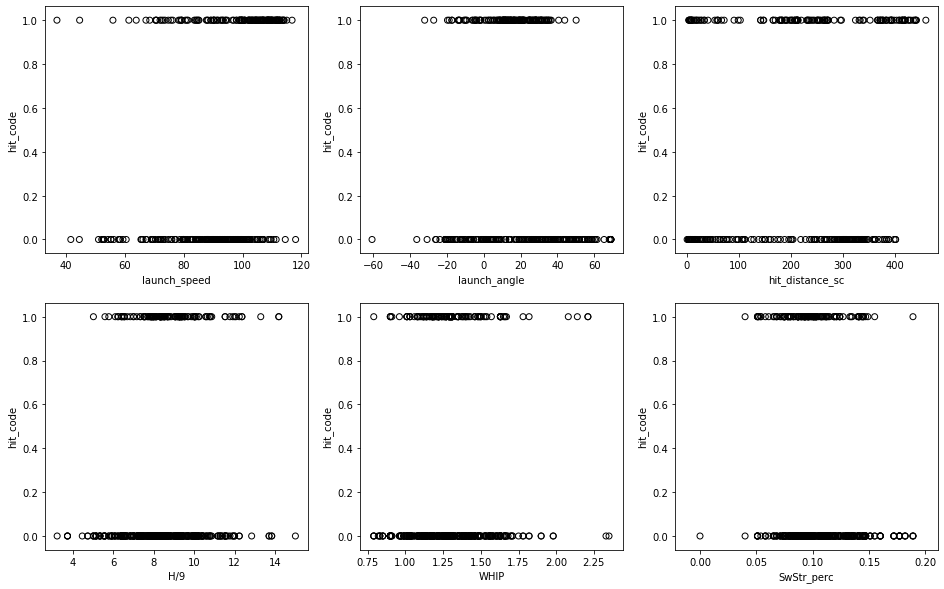

In [746]:
my_metric_list = (['launch_speed', 'launch_angle', 'hit_distance_sc',
                   'H/9', 'WHIP', 'SwStr_perc'])
visualize_log_regr_plots(my_metric_list, df_sc_trout_events_wpitcherinfo)

### Perhaps limit to pitcher's total batters faced

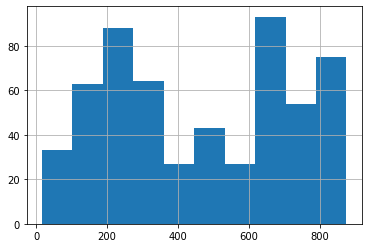

In [707]:
# Perhaps limit to pitcher's total batters faced

#df_sc_trout_events_wpitcherinfo['TBF'].hist()

In [708]:
df_sc_trout_events_wpitcherinfo_lt500 = df_sc_trout_events_wpitcherinfo[df_sc_trout_events_wpitcherinfo['TBF'] < 500]
df_sc_trout_events_wpitcherinfo_gt500 = df_sc_trout_events_wpitcherinfo[df_sc_trout_events_wpitcherinfo['TBF'] > 500]

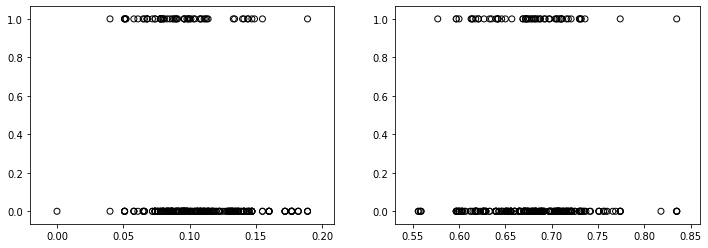

In [709]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df_sc_trout_events_wpitcherinfo_lt500['SwStr_perc'],
            df_sc_trout_events_wpitcherinfo_lt500['hit_code'],
            facecolors='none', edgecolors='k')

ax2.scatter(df_sc_trout_events_wpitcherinfo_lt500['Z-Swing_perc'],
            df_sc_trout_events_wpitcherinfo_lt500['hit_code'],
            facecolors='none', edgecolors='k')

In [684]:
df_sc_trout_events_wpitcherinfo.shape

(7575, 38)

In [685]:
df_sc_trout_events_wpitcherinfo.head()

,hit_code,events,hit_distance_sc,launch_speed,launch_angle,launch_speed,type,p_throws,home_team,if_fielding_alignment,...,Oppo_perc,Soft_perc,Med_perc,Hard_perc,Zone_perc,FA_perc _pfx,vFA _pfx,FA-X _pfx,FA-Z _pfx,key_mlbam
0,0,field_out,306.0,88.0,20.2,88.0,X,L,LAA,Standard,...,0.207,0.145,0.453,0.402,0.451,0.185,89.4,2.2,6.9,474463.0
1,0,field_out,306.0,88.0,20.2,88.0,X,L,LAA,Standard,...,0.210,0.173,0.472,0.354,0.408,0.180,91.0,4.1,9.0,474463.0
2,0,field_out,306.0,88.0,20.2,88.0,X,L,LAA,Standard,...,0.292,0.219,0.417,0.365,0.434,0.196,90.8,4.7,10.2,474463.0
3,0,field_out,306.0,88.0,20.2,88.0,X,L,LAA,Standard,...,0.207,0.145,0.453,0.402,0.451,0.185,89.4,2.2,6.9,474463.0
4,0,field_out,306.0,88.0,20.2,88.0,X,L,LAA,Standard,...,0.210,0.173,0.472,0.354,0.408,0.180,91.0,4.1,9.0,474463.0


In [682]:
df_pitching_stats_lastname_wpid_18['pitcher'].head()

0    474463.0
1    474463.0
2    474463.0
3    474463.0
4    474463.0
Name: pitcher, dtype: float64

In [667]:
df_pitching_stats_lastname.loc[:, df_pitching_stats_lastname.columns.str.contains('Zone_perc')]

,Zone_perc,Zone_perc _pfx,Zone_perc _pi
131,0.446,0.507,0.513
376,0.467,0.513,0.513
257,0.474,0.527,0.528
251,0.452,0.516,0.516
195,0.478,0.488,0.485
...,...,...,...
2174,0.411,0.500,0.508
2020,0.440,0.460,0.441
1825,0.455,0.488,0.488
1366,0.429,0.479,0.484


In [ ]:
col2keep_features = ['launch_speed', 'p_throws', 'home_team', '']


target = 'hit_code'

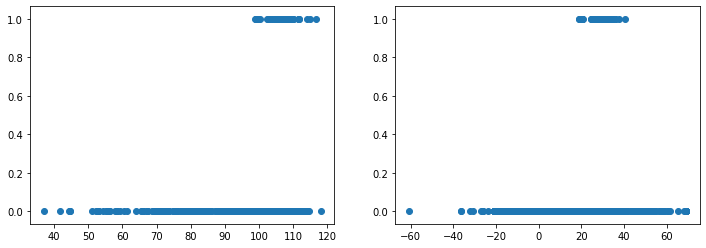

In [615]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df_sc_trout_events['launch_speed'],
            df_sc_trout_events['home_run_code'])

ax2.scatter(df_sc_trout_events['launch_angle'],
            df_sc_trout_events['home_run_code'])

In [619]:
from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import LogisticRegression

Add a quadratic component
https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.PolynomialFeatures.html

In [630]:
col2keep = ['launch_speed', 'launch_angle', 'home_run_code']
df_temp = df_sc_trout_events.loc[:, col2keep]
df_temp = df_temp.dropna(how='any',axis=0) 

In [631]:
df_temp.shape

(354, 3)

In [632]:
df_temp.head()

,launch_speed,launch_angle,home_run_code
2195,88.0,20.2,0
6080,101.6,40.8,0
6130,90.1,51.9,0
6262,91.5,27.1,0
11153,98.0,3.8,0


In [633]:
X = df_temp[['launch_speed', 'launch_angle']]
y = df_temp['home_run_code']

In [635]:
poly = PolynomialFeatures(degree=2)
poly.fit_transform(X)


array([[ 1.000000e+00,  8.800000e+01,  2.020000e+01,  7.744000e+03,
         1.777600e+03,  4.080400e+02],
       [ 1.000000e+00,  1.016000e+02,  4.080000e+01,  1.032256e+04,
         4.145280e+03,  1.664640e+03],
       [ 1.000000e+00,  9.010000e+01,  5.190000e+01,  8.118010e+03,
         4.676190e+03,  2.693610e+03],
       ...,
       [ 1.000000e+00,  9.060000e+01, -9.000000e-01,  8.208360e+03,
        -8.154000e+01,  8.100000e-01],
       [ 1.000000e+00,  9.830000e+01,  5.020000e+01,  9.662890e+03,
         4.934660e+03,  2.520040e+03],
       [ 1.000000e+00,  5.260000e+01,  9.000000e-01,  2.766760e+03,
         4.734000e+01,  8.100000e-01]])

In [636]:
clf = LogisticRegression(random_state=0).fit(X, y)

In [637]:
clf

LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
                   intercept_scaling=1, l1_ratio=None, max_iter=100,
                   multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=0, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)

In [646]:
# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
# plt.scatter(df_temp[['launch_speed',, y, color='black', zorder=20)
# X_test = np.linspace(-60, 60, 100)

# loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
# plt.plot(X_test, loss, color='red', linewidth=3)



<Figure size 288x216 with 0 Axes>

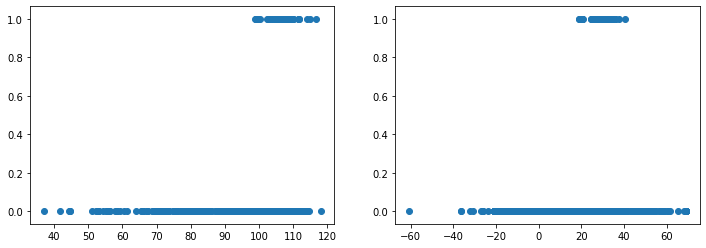

In [645]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df_sc_trout_events['launch_speed'],
            df_sc_trout_events['home_run_code'])
X_test = np.linspace(-60, 60, 100)


ax2.scatter(df_sc_trout_events['launch_angle'],
            df_sc_trout_events['home_run_code'])

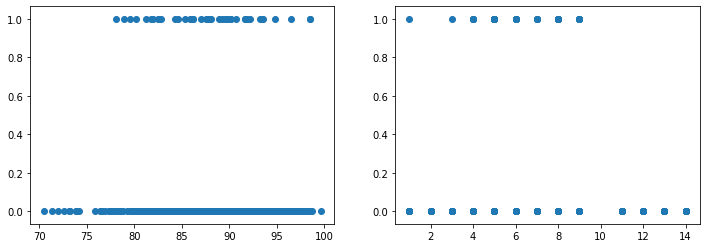

In [616]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

ax1.scatter(df_sc_trout_events['release_speed'],
            df_sc_trout_events['home_run_code'])

ax2.scatter(df_sc_trout_events['zone'],
            df_sc_trout_events['home_run_code'])

In [617]:
df_sc_trout_events['home_run_code'].sum()

39

In [ ]:
# Plot location of pitch for each type
    
    

## Leury Garcia - lower WAR

In [748]:
df_sc_lg = return_player_opp_pitcher_df(544725)

/Users/lacar/anaconda/envs/insight/lib/python3.6/site-packages/ipykernel_launcher.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  import sys


In [749]:
df_sc_lg.head()

,hit_code,events,player_name,hit_distance_sc,launch_speed,launch_angle,launch_speed,type,p_throws,home_team,...,Oppo_perc,Soft_perc,Med_perc,Hard_perc,Zone_perc,FA_perc _pfx,vFA _pfx,FA-X _pfx,FA-Z _pfx,key_mlbam
0,0,field_out,Trevor May,365.0,94.4,29.6,94.4,X,R,MIN,...,0.213,0.230,0.410,0.361,0.440,0.587,94.0,-3.5,8.9,543507.0
1,0,field_out,Taylor Rogers,173.0,108.8,4.8,108.8,X,L,MIN,...,0.270,0.168,0.491,0.341,0.475,0.154,93.2,9.2,5.9,573124.0
2,0,field_out,Taylor Rogers,173.0,95.3,7.6,95.3,X,L,MIN,...,0.270,0.168,0.491,0.341,0.475,0.154,93.2,9.2,5.9,573124.0
3,1,single,Taylor Rogers,191.0,99.5,12.2,99.5,X,L,CWS,...,0.270,0.168,0.491,0.341,0.475,0.154,93.2,9.2,5.9,573124.0
4,0,strikeout,Andrew Vasquez,NaN,NaN,NaN,NaN,S,L,MIN,...,0.429,0.071,0.714,0.214,0.406,0.030,88.9,9.7,6.1,607755.0


ValueError: x and y must be the same size

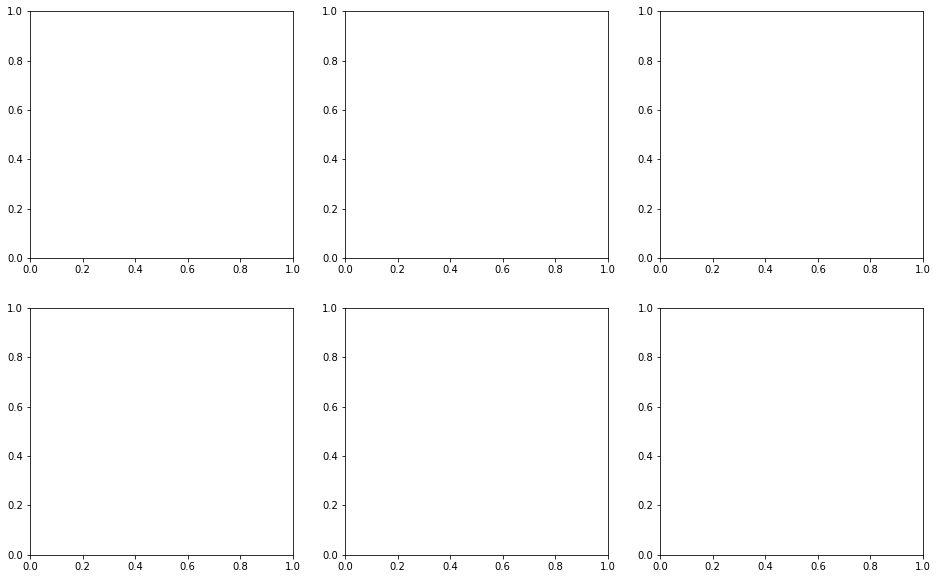

In [747]:
my_metric_list = (['launch_speed', 'launch_angle', 'hit_distance_sc',
                   'H/9', 'WHIP', 'SwStr_perc'])
visualize_log_regr_plots(my_metric_list, df_sc_lg)

## Many ways to bin data

https://www.baseball-reference.com/players/split.fcgi?id=reyesfr01&t=b&year=2019

# A - EDA - identifying features that correlate with HR

## Factors that correlate with HR from research

https://fivethirtyeight.com/features/you-cant-have-home-runs-without-strikeouts/
<br>
see also ...Edu_Data_Science/Insight/devsetupbeforecomingtoinsight/insight_baseball_notes/Full_Report_of_..

In [434]:
df_sc.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,0,FC,2018-10-01,92.2,-1.9690,6.2644,Kenley Jansen,467827.0,445276.0,strikeout,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
1,1,FC,2018-10-01,93.0,-1.7689,6.2976,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
2,2,FC,2018-10-01,91.6,-1.7451,6.2154,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
3,3,FF,2018-10-01,93.1,-1.4250,6.1929,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
4,4,FC,2018-10-01,91.4,-1.9144,6.2641,Kenley Jansen,435622.0,445276.0,strikeout,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard


Note - df_sc is 2018 only

## Inspect ESPN 300 set

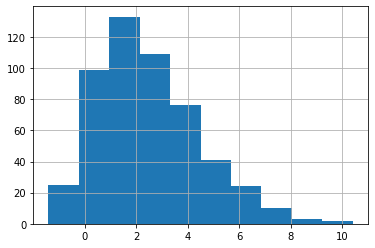

In [712]:
df_espn300_w_batting['WAR'].hist()

In [713]:
df_espn300_w_batting[df_espn300_w_batting['WAR'] < 2]

,rank,player,team,elig_pos,pos_rank,age,Season,Name,Team,Age,...,O-Swing_perc _pi,Z-Swing_perc _pi,Swing_perc _pi,O-Contact_perc _pi,Z-Contact_perc _pi,Contact_perc _pi,Zone_perc _pi,Pace _pi,HR_per_ab,SO_per_ab
33,15,Trevor Story,COL,SS,SS4,26,2017.0,Trevor Story,Rockies,24.0,...,0.322,0.660,0.483,0.509,0.808,0.704,0.477,26.7,0.047714,0.379722
42,18,Starling Marte,PIT,OF,OF8,30,2017.0,Starling Marte,Pirates,28.0,...,0.362,0.642,0.494,0.615,0.895,0.786,0.471,23.8,0.022654,0.203883
59,26,Rafael Devers,BOS,3B,3B5,22,2018.0,Rafael Devers,Red Sox,21.0,...,0.362,0.713,0.519,0.613,0.826,0.744,0.449,23.5,0.046667,0.268889
60,26,Rafael Devers,BOS,3B,3B5,22,2017.0,Rafael Devers,Red Sox,20.0,...,0.385,0.648,0.507,0.665,0.817,0.754,0.462,23.2,0.045045,0.256757
89,39,Michael Brantley,HOU,OF,OF16,32,2017.0,Michael Brantley,Indians,30.0,...,0.276,0.617,0.441,0.760,0.951,0.890,0.484,26.9,0.026627,0.147929
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
519,297,Anthony Santander,BAL,OF,OF92,24,2017.0,Anthony Santander,Orioles,22.0,...,0.536,0.726,0.617,0.595,0.784,0.689,0.425,25.8,0.000000,0.266667
520,297,Anthony Santander,BAL,OF,OF92,24,2018.0,Anthony Santander,Orioles,23.0,...,0.390,0.661,0.507,0.677,0.846,0.772,0.431,25.0,0.009901,0.207921
522,300,Leury Garcia,CWS,OF/SS,OF94,28,2019.0,Leury Garcia,White Sox,28.0,...,0.375,0.690,0.538,0.583,0.870,0.774,0.518,23.6,0.013865,0.240901
523,300,Leury Garcia,CWS,OF/SS,OF94,28,2017.0,Leury Garcia,White Sox,26.0,...,0.361,0.710,0.543,0.621,0.867,0.789,0.521,22.1,0.030000,0.230000


In [547]:
df_espn300_w_batting = pd.merge(df_espn_300_hitters, df_batting_stats, how='left', left_on='player' , right_on='Name')

In [550]:
df_espn300_w_batting

,rank,player,team,elig_pos,pos_rank,age,Season,Name,Team,Age,...,wSL/C _pi,wXX/C _pi,O-Swing_perc _pi,Z-Swing_perc _pi,Swing_perc _pi,O-Contact_perc _pi,Z-Contact_perc _pi,Contact_perc _pi,Zone_perc _pi,Pace _pi
0,1,Mike Trout,LAA,OF,OF1,28,2018.0,Mike Trout,Angels,26.0,...,2.55,-5.67,0.198,0.555,0.376,0.660,0.903,0.839,0.498,23.3
1,1,Mike Trout,LAA,OF,OF1,28,2019.0,Mike Trout,Angels,27.0,...,2.44,-3.09,0.191,0.559,0.368,0.653,0.884,0.822,0.481,23.6
2,1,Mike Trout,LAA,OF,OF1,28,2017.0,Mike Trout,Angels,25.0,...,1.94,NaN,0.209,0.580,0.378,0.716,0.880,0.831,0.457,23.8
3,2,Ronald Acuna Jr.,ATL,OF,OF2,21,2019.0,Ronald Acuna Jr.,Braves,21.0,...,0.55,NaN,0.258,0.675,0.454,0.629,0.787,0.739,0.471,23.8
4,2,Ronald Acuna Jr.,ATL,OF,OF2,21,2018.0,Ronald Acuna Jr.,Braves,20.0,...,0.31,NaN,0.258,0.688,0.461,0.587,0.809,0.743,0.471,22.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
520,297,Anthony Santander,BAL,OF,OF92,24,2018.0,Anthony Santander,Orioles,23.0,...,1.72,NaN,0.390,0.661,0.507,0.677,0.846,0.772,0.431,25.0
521,298,Mike Yastrzemski,SF,OF,OF93,29,2019.0,Mike Yastrzemski,Giants,28.0,...,1.32,NaN,0.291,0.649,0.471,0.619,0.814,0.754,0.503,24.2
522,300,Leury Garcia,CWS,OF/SS,OF94,28,2019.0,Leury Garcia,White Sox,28.0,...,-1.60,NaN,0.375,0.690,0.538,0.583,0.870,0.774,0.518,23.6
523,300,Leury Garcia,CWS,OF/SS,OF94,28,2017.0,Leury Garcia,White Sox,26.0,...,3.51,NaN,0.361,0.710,0.543,0.621,0.867,0.789,0.521,22.1


In [555]:
print(colored('Careful - this has 3 seasons so each player may be represented 3 times', 'red',
     attrs=['bold']))

Careful - this has 3 seasons so each player may be represented 3 times


In [558]:
print(colored('No. of at-bats', 'blue', attrs=['bold']))

No. of at-bats


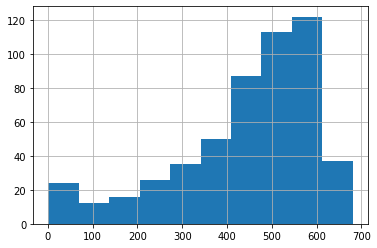

In [551]:
df_espn300_w_batting['AB'].hist()

In [561]:
df_espn300_w_batting['HR_per_ab'] = df_espn300_w_batting['HR']/df_espn300_w_batting['AB']
df_espn300_w_batting['SO_per_ab'] = df_espn300_w_batting['SO']/df_espn300_w_batting['AB']

## Batter strikeouts per at-bat

In [517]:
df_batting_stats.head()

,Season,Name,Team,Age,G,AB,PA,H,1B,2B,...,wSL/C _pi,wXX/C _pi,O-Swing_perc _pi,Z-Swing_perc _pi,Swing_perc _pi,O-Contact_perc _pi,Z-Contact_perc _pi,Contact_perc _pi,Zone_perc _pi,Pace _pi
63,2018.0,Mookie Betts,Red Sox,25.0,136.0,520.0,614.0,180.0,96.0,47.0,...,1.93,NaN,0.185,0.535,0.356,0.658,0.926,0.855,0.490,23.3
67,2018.0,Mike Trout,Angels,26.0,140.0,471.0,608.0,147.0,80.0,24.0,...,2.55,-5.67,0.198,0.555,0.376,0.660,0.903,0.839,0.498,23.3
86,2019.0,Mike Trout,Angels,27.0,134.0,470.0,600.0,137.0,63.0,27.0,...,2.44,-3.09,0.191,0.559,0.368,0.653,0.884,0.822,0.481,23.6
101,2019.0,Alex Bregman,Astros,25.0,156.0,554.0,690.0,164.0,84.0,37.0,...,1.28,NaN,0.169,0.552,0.349,0.724,0.920,0.870,0.471,26.0
96,2017.0,Aaron Judge,Yankees,25.0,155.0,542.0,678.0,154.0,75.0,24.0,...,-0.71,NaN,0.260,0.632,0.411,0.417,0.829,0.674,0.407,24.4


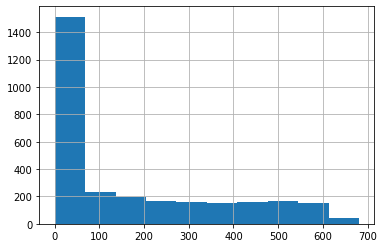

In [521]:
df_batting_stats['AB'].hist()

correlation coefficient (min 200 ab):  0.33756529126852003
correlation coefficient (ESPN 300):  nan


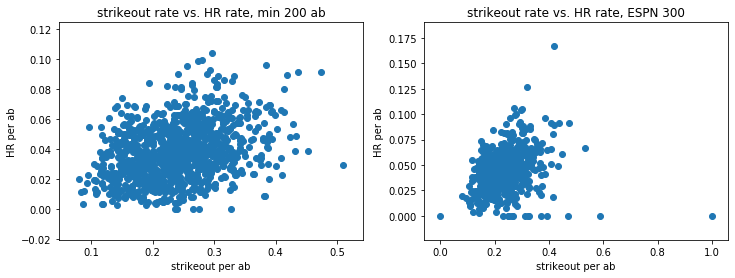

In [565]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

df_batting_min100ab = df_batting_stats[df_batting_stats['AB']>200]
x_metric = df_batting_min100ab['SO']/df_batting_min100ab['AB']
y_metric = df_batting_min100ab['HR']/df_batting_min100ab['AB']
ax1.scatter(x_metric, y_metric)
ax1.set_title('strikeout rate vs. HR rate, min 200 ab')
ax1.set_xlabel('strikeout per ab')
ax1.set_ylabel('HR per ab')

print('correlation coefficient (min 200 ab): ', np.corrcoef(x_metric, y_metric)[0, 1])


x_metric = df_espn300_w_batting['SO_per_ab']
y_metric = df_espn300_w_batting['HR_per_ab']
ax2.scatter(x_metric, y_metric)
ax2.set_title('strikeout rate vs. HR rate, ESPN 300')
ax2.set_xlabel('strikeout per ab')
ax2.set_ylabel('HR per ab')

print('correlation coefficient (ESPN 300): ', np.corrcoef(x_metric, y_metric)[0, 1])


In [566]:
[i for i in df_espn300_w_batting.columns]

['rank',
 'player',
 'team',
 'elig_pos',
 'pos_rank',
 'age',
 'Season',
 'Name',
 'Team',
 'Age',
 'G',
 'AB',
 'PA',
 'H',
 '1B',
 '2B',
 '3B',
 'HR',
 'R',
 'RBI',
 'BB',
 'IBB',
 'SO',
 'HBP',
 'SF',
 'SH',
 'GDP',
 'SB',
 'CS',
 'AVG',
 'GB',
 'FB',
 'LD',
 'IFFB',
 'Pitches',
 'Balls',
 'Strikes',
 'IFH',
 'BU',
 'BUH',
 'BB_perc',
 'K_perc',
 'BB/K',
 'OBP',
 'SLG',
 'OPS',
 'ISO',
 'BABIP',
 'GB/FB',
 'LD_perc',
 'GB_perc',
 'FB_perc',
 'IFFB_perc',
 'HR/FB',
 'IFH_perc',
 'BUH_perc',
 'wOBA',
 'wRAA',
 'wRC',
 'Bat',
 'Fld',
 'Rep',
 'Pos',
 'RAR',
 'WAR',
 'Dol',
 'Spd',
 'wRC+',
 'WPA',
 '-WPA',
 '+WPA',
 'RE24',
 'REW',
 'pLI',
 'phLI',
 'PH',
 'WPA/LI',
 'Clutch',
 'FB_perc _Pitch',
 'FBv',
 'SL_perc',
 'SLv',
 'CT_perc',
 'CTv',
 'CB_perc',
 'CBv',
 'CH_perc',
 'CHv',
 'SF_perc',
 'SFv',
 'KN_perc',
 'KNv',
 'XX_perc',
 'PO_perc',
 'wFB',
 'wSL',
 'wCT',
 'wCB',
 'wCH',
 'wSF',
 'wKN',
 'wFB/C',
 'wSL/C',
 'wCT/C',
 'wCB/C',
 'wCH/C',
 'wSF/C',
 'wKN/C',
 'O-Swing_perc',

correlation coefficient (min 200 ab):  nan
careful - HR is an input to wOBA


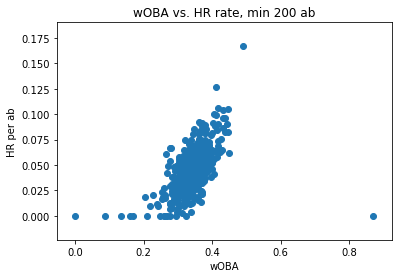

In [572]:
f, (ax1) = plt.subplots(1, 1)

x_metric = df_espn300_w_batting['wOBA']
y_metric = df_espn300_w_batting['HR']/df_espn300_w_batting['AB']
ax1.scatter(x_metric, y_metric)
ax1.set_title('wOBA vs. HR rate, min 200 ab')
ax1.set_xlabel('wOBA')
ax1.set_ylabel('HR per ab')

print('correlation coefficient (min 200 ab): ', np.corrcoef(x_metric, y_metric)[0, 1])
print(colored('careful - HR is an input to wOBA', 'red'))


In [573]:
df_espn300_w_batting.describe()

,rank,age,Season,Age,G,AB,PA,H,1B,2B,...,O-Swing_perc _pi,Z-Swing_perc _pi,Swing_perc _pi,O-Contact_perc _pi,Z-Contact_perc _pi,Contact_perc _pi,Zone_perc _pi,Pace _pi,HR_per_ab,SO_per_ab
count,525.000000,525.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,522.000000,...,522.00000,522.000000,522.000000,521.000000,521.000000,522.000000,522.000000,522.000000,522.000000,522.000000
mean,144.925714,28.201905,2018.059387,27.095785,121.950192,440.741379,495.164751,118.846743,72.168582,24.333333,...,0.30990,0.657383,0.472534,0.609743,0.854299,0.768761,0.466743,24.646169,0.044280,0.243100
std,87.161166,3.469221,0.813937,3.453894,38.187503,156.175132,176.401870,46.302140,30.763826,10.795072,...,0.06522,0.066481,0.052470,0.097766,0.050421,0.069035,0.029664,1.689846,0.021380,0.078877
min,1.000000,20.000000,2017.000000,19.000000,1.000000,1.000000,1.000000,0.000000,0.000000,0.000000,...,0.00000,0.000000,0.333000,0.000000,0.571000,0.000000,0.200000,18.300000,0.000000,0.000000
25%,72.000000,26.000000,2017.000000,25.000000,105.000000,373.250000,414.500000,95.000000,55.000000,18.000000,...,0.26700,0.620000,0.437250,0.549000,0.820000,0.733250,0.451000,23.600000,0.029458,0.191461
50%,143.000000,28.000000,2018.000000,27.000000,136.000000,480.000000,540.500000,125.000000,74.000000,25.000000,...,0.30850,0.659000,0.472000,0.613000,0.859000,0.771000,0.468000,24.400000,0.043601,0.240166
75%,218.000000,30.000000,2019.000000,29.000000,151.000000,557.000000,630.750000,153.750000,95.000000,32.000000,...,0.34875,0.693750,0.504750,0.678000,0.891000,0.809750,0.482000,25.600000,0.057008,0.283296
max,300.000000,39.000000,2019.000000,38.000000,162.000000,681.000000,747.000000,213.000000,170.000000,58.000000,...,0.53600,0.867000,0.622000,0.818000,1.000000,1.000000,0.667000,30.000000,0.166667,1.000000


In [575]:
perc_columns = df_espn300_w_batting.columns[df_espn300_w_batting.columns.str.contains('perc')]

In [583]:
perc_columns.tolist() + ['HR_per_ab', 'SO_per_ab']

['BB_perc',
 'K_perc',
 'LD_perc',
 'GB_perc',
 'FB_perc',
 'IFFB_perc',
 'IFH_perc',
 'BUH_perc',
 'FB_perc _Pitch',
 'SL_perc',
 'CT_perc',
 'CB_perc',
 'CH_perc',
 'SF_perc',
 'KN_perc',
 'XX_perc',
 'PO_perc',
 'O-Swing_perc',
 'Z-Swing_perc',
 'Swing_perc',
 'O-Contact_perc',
 'Z-Contact_perc',
 'Contact_perc',
 'Zone_perc',
 'F-Strike_perc',
 'SwStr_perc',
 'FA_perc _pfx',
 'FT_perc _pfx',
 'FC_perc _pfx',
 'FS_perc _pfx',
 'FO_perc _pfx',
 'SI_perc _pfx',
 'SL_perc _pfx',
 'CU_perc _pfx',
 'KC_perc _pfx',
 'EP_perc _pfx',
 'CH_perc _pfx',
 'SC_perc _pfx',
 'KN_perc _pfx',
 'UN_perc _pfx',
 'O-Swing_perc _pfx',
 'Z-Swing_perc _pfx',
 'Swing_perc _pfx',
 'O-Contact_perc _pfx',
 'Z-Contact_perc _pfx',
 'Contact_perc _pfx',
 'Zone_perc _pfx',
 'Pull_perc',
 'Cent_perc',
 'Oppo_perc',
 'Soft_perc',
 'Med_perc',
 'Hard_perc',
 'TTO_perc',
 'CH_perc _pi',
 'CS_perc _pi',
 'CU_perc _pi',
 'FA_perc _pi',
 'FC_perc _pi',
 'FS_perc _pi',
 'KN_perc _pi',
 'SB_perc _pi',
 'SI_perc _pi',
 'SL

In [584]:
corr_perc = df_espn300_w_batting[perc_columns.tolist() + ['HR_per_ab', 'SO_per_ab']].corr()
corr_perc

,BB_perc,K_perc,LD_perc,GB_perc,FB_perc,IFFB_perc,IFH_perc,BUH_perc,FB_perc _Pitch,SL_perc,...,XX_perc _pi,O-Swing_perc _pi,Z-Swing_perc _pi,Swing_perc _pi,O-Contact_perc _pi,Z-Contact_perc _pi,Contact_perc _pi,Zone_perc _pi,HR_per_ab,SO_per_ab
BB_perc,1.000000,0.051518,-0.075698,-0.138806,0.277241,-0.134237,-0.133440,0.029204,-0.019686,-0.168202,...,-0.148971,-0.691194,-0.309468,-0.681017,-0.089845,-0.139935,-0.003636,-0.075572,0.402096,0.174504
K_perc,0.051518,1.000000,-0.199753,-0.183173,0.058862,-0.010981,0.001499,-0.112169,-0.358054,0.311044,...,0.033349,0.150353,-0.125655,0.028255,-0.764758,-0.744921,-0.889897,-0.460173,0.209877,0.989661
LD_perc,-0.075698,-0.199753,1.000000,-0.412080,-0.156417,-0.247827,-0.083661,0.022499,0.391554,-0.160083,...,-0.048302,-0.137861,0.017634,-0.042106,0.112767,0.183437,0.243081,0.277123,-0.105581,-0.194304
GB_perc,-0.138806,-0.183173,-0.412080,1.000000,-0.677628,-0.056388,0.170394,-0.043472,0.071130,-0.124764,...,0.122406,0.146625,0.178217,0.164599,0.144464,0.076938,0.150521,0.065495,-0.378449,-0.198235
FB_perc,0.277241,0.058862,-0.156417,-0.677628,1.000000,0.290516,-0.073240,0.049404,-0.176372,-0.028253,...,-0.111149,-0.140949,0.050319,-0.116441,-0.054245,-0.219392,-0.048899,-0.035426,0.553018,0.107475
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z-Contact_perc _pi,-0.139935,-0.744921,0.183437,0.076938,-0.219392,0.026372,-0.045151,0.056348,0.252789,-0.092957,...,-0.131874,-0.141206,-0.289434,-0.193076,0.558483,1.000000,0.873744,0.304497,-0.400492,-0.750355
Contact_perc _pi,-0.003636,-0.889897,0.243081,0.150521,-0.048899,0.040184,-0.001007,0.116667,0.472700,-0.393952,...,-0.183679,-0.262343,-0.053316,-0.185055,0.849692,0.873744,1.000000,0.571718,-0.301883,-0.877906
Zone_perc _pi,-0.075572,-0.460173,0.277123,0.065495,-0.035426,-0.024149,0.077916,0.107568,0.555954,-0.357841,...,-0.110043,-0.389558,-0.151165,-0.221700,0.371506,0.304497,0.571718,1.000000,-0.262679,-0.447059
HR_per_ab,0.402096,0.209877,-0.105581,-0.378449,0.553018,0.041938,-0.117322,-0.055464,-0.261847,0.115414,...,0.128820,-0.166570,0.071966,-0.137178,-0.295741,-0.400492,-0.301883,-0.262679,1.000000,0.271596


In [590]:
corr_perc.sort_values(by='HR_per_ab', ascending=False)

,BB_perc,K_perc,LD_perc,GB_perc,FB_perc,IFFB_perc,IFH_perc,BUH_perc,FB_perc _Pitch,SL_perc,...,XX_perc _pi,O-Swing_perc _pi,Z-Swing_perc _pi,Swing_perc _pi,O-Contact_perc _pi,Z-Contact_perc _pi,Contact_perc _pi,Zone_perc _pi,HR_per_ab,SO_per_ab
HR_per_ab,0.402096,0.209877,-0.105581,-0.378449,0.553018,0.041938,-0.117322,-0.055464,-0.261847,0.115414,...,0.128820,-0.166570,0.071966,-0.137178,-0.295741,-0.400492,-0.301883,-0.262679,1.000000,0.271596
FB_perc,0.277241,0.058862,-0.156417,-0.677628,1.000000,0.290516,-0.073240,0.049404,-0.176372,-0.028253,...,-0.111149,-0.140949,0.050319,-0.116441,-0.054245,-0.219392,-0.048899,-0.035426,0.553018,0.107475
Hard_perc,0.284863,0.186406,0.358845,-0.437708,0.225018,-0.084793,-0.205813,-0.109350,-0.096569,0.197635,...,-0.028054,-0.287516,-0.034270,-0.211588,-0.343398,-0.211968,-0.230754,-0.085187,0.537512,0.227863
TTO_perc,0.501375,0.868958,-0.213248,-0.277532,0.268442,-0.050471,-0.073491,-0.090982,-0.352884,0.213224,...,-0.015329,-0.172694,-0.199156,-0.260064,-0.716417,-0.700628,-0.781444,-0.455327,0.530670,0.919441
BB_perc,1.000000,0.051518,-0.075698,-0.138806,0.277241,-0.134237,-0.133440,0.029204,-0.019686,-0.168202,...,-0.148971,-0.691194,-0.309468,-0.681017,-0.089845,-0.139935,-0.003636,-0.075572,0.402096,0.174504
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
Z-Contact_perc,-0.140619,-0.760948,0.151527,0.069464,-0.187958,0.069407,-0.015141,0.081964,0.260700,-0.090992,...,-0.151257,-0.155097,-0.302432,-0.199823,0.624952,0.957589,0.895961,0.358461,-0.388969,-0.766044
Z-Contact_perc _pfx,-0.158911,-0.744950,0.185529,0.067399,-0.210360,0.050011,-0.028054,0.053745,0.245784,-0.077027,...,-0.101998,-0.135126,-0.293578,-0.188903,0.566347,0.990405,0.873730,0.317224,-0.391609,-0.752120
Z-Contact_perc _pi,-0.139935,-0.744921,0.183437,0.076938,-0.219392,0.026372,-0.045151,0.056348,0.252789,-0.092957,...,-0.131874,-0.141206,-0.289434,-0.193076,0.558483,1.000000,0.873744,0.304497,-0.400492,-0.750355
Med_perc,-0.187718,-0.227638,-0.176110,0.282721,-0.185862,-0.245116,0.127715,0.105418,0.084181,-0.166957,...,-0.019875,0.181736,0.040629,0.146213,0.349850,0.237048,0.267707,0.093387,-0.459535,-0.256941


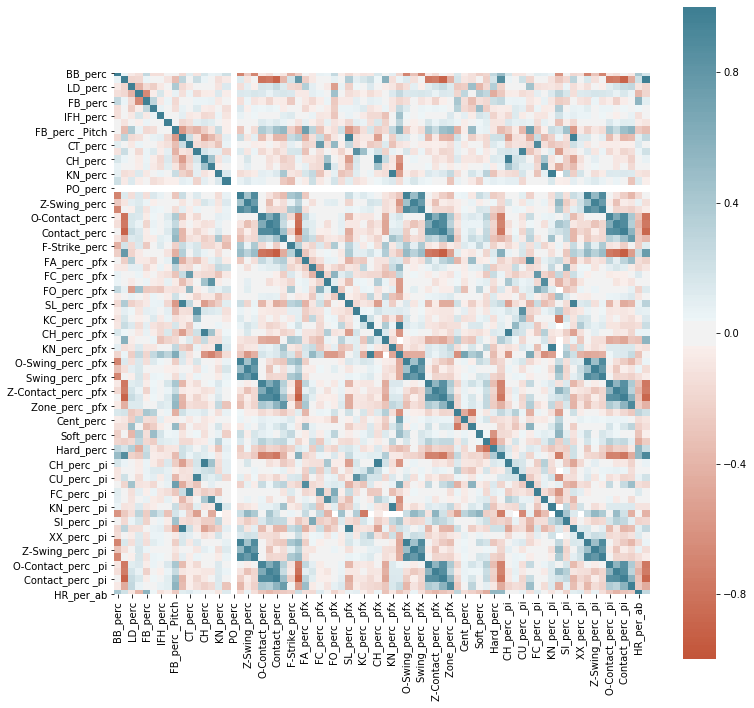

In [588]:
f, ax1 = plt.subplots(figsize=(12,12))

ax1 = sns.heatmap(
    corr_perc, 
    vmin=-1, vmax=1, center=0,
    cmap=sns.diverging_palette(20, 220, n=200),
    square=True
)

In [592]:
df_espn300_w_batting.head()

,rank,player,team,elig_pos,pos_rank,age,Season,Name,Team,Age,...,O-Swing_perc _pi,Z-Swing_perc _pi,Swing_perc _pi,O-Contact_perc _pi,Z-Contact_perc _pi,Contact_perc _pi,Zone_perc _pi,Pace _pi,HR_per_ab,SO_per_ab
0,1,Mike Trout,LAA,OF,OF1,28,2018.0,Mike Trout,Angels,26.0,...,0.198,0.555,0.376,0.660,0.903,0.839,0.498,23.3,0.082803,0.263270
1,1,Mike Trout,LAA,OF,OF1,28,2019.0,Mike Trout,Angels,27.0,...,0.191,0.559,0.368,0.653,0.884,0.822,0.481,23.6,0.095745,0.255319
2,1,Mike Trout,LAA,OF,OF1,28,2017.0,Mike Trout,Angels,25.0,...,0.209,0.580,0.378,0.716,0.880,0.831,0.457,23.8,0.082090,0.223881
3,2,Ronald Acuna Jr.,ATL,OF,OF2,21,2019.0,Ronald Acuna Jr.,Braves,21.0,...,0.258,0.675,0.454,0.629,0.787,0.739,0.471,23.8,0.065495,0.300319
4,2,Ronald Acuna Jr.,ATL,OF,OF2,21,2018.0,Ronald Acuna Jr.,Braves,20.0,...,0.258,0.688,0.461,0.587,0.809,0.743,0.471,22.0,0.060046,0.284065


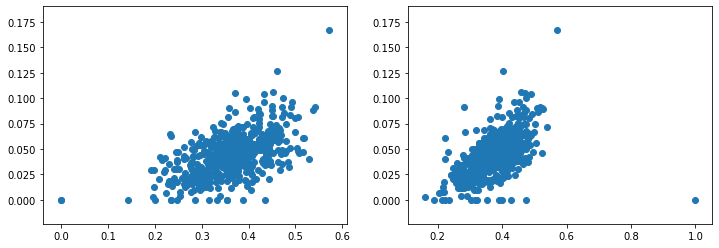

In [595]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
ax1.scatter(df_espn300_w_batting['FB_perc'], df_espn300_w_batting['HR_per_ab']);

ax2.scatter(df_espn300_w_batting['Hard_perc'], df_espn300_w_batting['HR_per_ab']);



## Batter launch speed and launch angle

In [435]:
df_sc.shape

(721190, 90)

In [436]:
df_sc_events = df_sc[df_sc['events'].notna()]

In [437]:
df_sc_events.shape

(184612, 90)

In [ ]:
# Show all events
# f, ax1 = plt.subplots(1, 1)
# ax1.scatter(df_sc_events_df_sc_events

In [438]:
df_sc_events_hr = df_sc_events[df_sc_events['events']=='home_run'].copy()

In [439]:
df_sc_events_hr.shape

(5585, 90)

In [ ]:
f, ax1 = plt.subplots(1, 1)
ax1.scatter(df_sc_events_hr['launch_speed'], df_sc_events_hr['launch_angle'])

In [596]:
event_list = ['single', 'double', 'triple', 'home_run', ]

In [597]:
#df_sc_events['events'].unique()

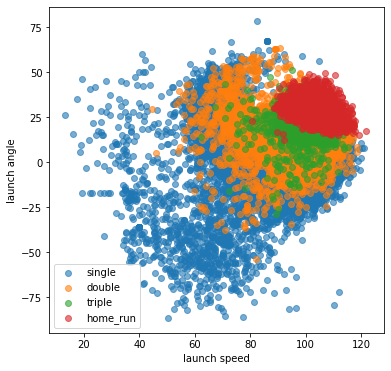

In [598]:
f, ax1 = plt.subplots(1, 1, figsize=(6,6))
for event in event_list:
    df_sc_events_temp = df_sc_events[df_sc_events['events']==event].copy()
    ax1.scatter(df_sc_events_temp['launch_speed'],
                df_sc_events_temp['launch_angle'], alpha=0.6,
                label=event)
    
ax1.set_xlabel('launch speed')
ax1.set_ylabel('launch angle')
ax1.legend();

## Batter WAR



## Opposing pitcher WAR

In [ ]:
df_sc

In [461]:
df_pitching_stats.head()

,Season,Name,Team,Age,W,L,ERA,WAR,G,GS,...,wSL/C _pi,wXX/C _pi,O-Swing_perc _pi,Z-Swing_perc _pi,Swing_perc _pi,O-Contact_perc _pi,Z-Contact_perc _pi,Contact_perc _pi,Zone_perc _pi,Pace _pi
131,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,32.0,...,2.25,NaN,0.367,0.661,0.518,0.524,0.804,0.708,0.513,21.9
376,2017.0,Chris Sale,Red Sox,28.0,17.0,8.0,2.90,7.6,32.0,32.0,...,0.67,NaN,0.373,0.619,0.499,0.540,0.798,0.704,0.513,20.9
257,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,33.0,...,1.85,NaN,0.355,0.666,0.519,0.513,0.774,0.690,0.528,24.2
251,2019.0,Gerrit Cole,Astros,28.0,20.0,5.0,2.50,7.4,33.0,33.0,...,1.88,NaN,0.340,0.646,0.498,0.481,0.751,0.662,0.516,22.9
195,2017.0,Corey Kluber,Indians,31.0,18.0,4.0,2.25,7.2,29.0,29.0,...,4.65,9.31,0.388,0.595,0.489,0.433,0.853,0.681,0.485,23.5


In [474]:
df_pitching_stats.shape

(2345, 299)

In [473]:
df_temp_pitch_4lastname = df_pitching_stats['Name'].str.split(expand=True)

In [495]:
df_temp_pitch_4lastname.head()

,0,1,2,3
131,Jacob,deGrom,None,None
376,Chris,Sale,None,None
257,Max,Scherzer,None,None
251,Gerrit,Cole,None,None
195,Corey,Kluber,None,None


In [494]:
# Ignore those that don't have two names for now
print('No. of total pitchers: ', df_temp_pitch_4lastname.shape[0])
print('No. of pitchers who have last name in second row: ', df_temp_pitch_4lastname[2].isnull().sum())

No. of total pitchers:  2345
No. of pitchers who have last name in second row:  2313


In [492]:
df_temp_pitch_4lastname

2313

In [501]:
df_temp_pitch_4lastname.head()

,0,1,2,3
131,Jacob,deGrom,None,None
376,Chris,Sale,None,None
257,Max,Scherzer,None,None
251,Gerrit,Cole,None,None
195,Corey,Kluber,None,None


In [508]:
pd.DataFrame([df_temp_pitch_4lastname[0].str.lower(),
              df_temp_pitch_4lastname[1].str.lower()]).T

,0,1
131,jacob,degrom
376,chris,sale
257,max,scherzer
251,gerrit,cole
195,corey,kluber
...,...,...
2174,dan,straily
2020,dylan,covey
1825,chris,beck
1366,jarlin,garcia


In [497]:
df_pitching_stats_lastname = df_pitching_stats.loc[df_temp_pitch_4lastname.index, :]

In [512]:
df_pitching_stats_lastname.loc[:, 'first_name'] = df_temp_pitch_4lastname[0].str.lower()
df_pitching_stats_lastname.loc[:, 'last_name'] = df_temp_pitch_4lastname[1].str.lower()

In [514]:
# Merge pid info with WAR data from pitching stats

df_pitching_stats_lastname_wpid = pd.merge(df_pitching_stats_lastname, 
                                           df_pid, how='left',
                                           left_on=['first_name', 'last_name'],
                                           right_on=['name_first', 'name_last'])


df_pitching_stats_lastname_wpid

In [599]:
df_pitching_stats_lastname_wpid.head()

,Season,Name,Team,Age,W,L,ERA,WAR,G,GS,...,first_name,last_name,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,2018.0,Jacob deGrom,Mets,30.0,10.0,9.0,1.70,9.0,32.0,32.0,...,jacob,degrom,degrom,jacob,594798.0,degrj001,degroja01,10954.0,2014.0,2019.0
1,2017.0,Chris Sale,Red Sox,28.0,17.0,8.0,2.90,7.6,32.0,32.0,...,chris,sale,sale,chris,519242.0,salec001,salech01,10603.0,2010.0,2019.0
2,2018.0,Max Scherzer,Nationals,33.0,18.0,7.0,2.53,7.5,33.0,33.0,...,max,scherzer,scherzer,max,453286.0,schem001,scherma01,3137.0,2008.0,2019.0
3,2019.0,Gerrit Cole,Astros,28.0,20.0,5.0,2.50,7.4,33.0,33.0,...,gerrit,cole,cole,gerrit,543037.0,coleg001,colege01,13125.0,2013.0,2019.0
4,2017.0,Corey Kluber,Indians,31.0,18.0,4.0,2.25,7.2,29.0,29.0,...,corey,kluber,kluber,corey,446372.0,klubc001,klubeco01,2429.0,2011.0,2019.0


In [601]:
[i for i in df_pitching_stats_lastname_wpid.columns]

['Season',
 'Name',
 'Team',
 'Age',
 'W',
 'L',
 'ERA',
 'WAR',
 'G',
 'GS',
 'CG',
 'ShO',
 'SV',
 'BS',
 'IP',
 'TBF',
 'H',
 'R',
 'ER',
 'HR',
 'BB',
 'IBB',
 'HBP',
 'WP',
 'BK',
 'SO',
 'GB',
 'FB',
 'LD',
 'IFFB',
 'Balls',
 'Strikes',
 'Pitches',
 'RS',
 'IFH',
 'BU',
 'BUH',
 'K/9',
 'BB/9',
 'K/BB',
 'H/9',
 'HR/9',
 'AVG',
 'WHIP',
 'BABIP',
 'LOB_perc',
 'FIP',
 'GB/FB',
 'LD_perc',
 'GB_perc',
 'IFFB_perc',
 'HR/FB',
 'IFH_perc',
 'BUH_perc',
 'Starting',
 'Start-IP',
 'Relieving',
 'Relief-IP',
 'RAR',
 'Dollars',
 'tERA',
 'xFIP',
 'WPA',
 '-WPA',
 '+WPA',
 'RE24',
 'REW',
 'pLI',
 'inLI',
 'gmLI',
 'exLI',
 'Pulls',
 'WPA/LI',
 'Clutch',
 'FB_perc',
 'FBv',
 'SL_perc',
 'SLv',
 'CT_perc',
 'CTv',
 'CB_perc',
 'CBv',
 'CH_perc',
 'CHv',
 'SF_perc',
 'SFv',
 'KN_perc',
 'KNv',
 'XX_perc',
 'PO_perc',
 'wFB',
 'wSL',
 'wCT',
 'wCB',
 'wCH',
 'wSF',
 'wKN',
 'wFB/C',
 'wSL/C',
 'wCT/C',
 'wCB/C',
 'wCH/C',
 'wSF/C',
 'wKN/C',
 'O-Swing_perc',
 'Z-Swing_perc',
 'Swing_perc'

In [663]:
#df_pitching_stats_lastname_wpid.to_sql('pitching_stats_wpid', engine, if_exists='replace')

Text(0, 0.5, 'pitcher HR given up')

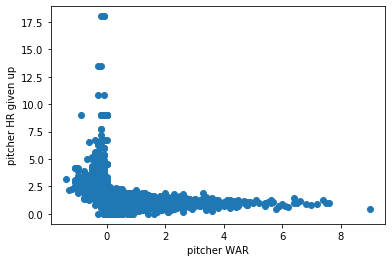

In [602]:
f, ax1 = plt.subplots()
ax1.scatter(df_pitching_stats_lastname_wpid['WAR'],
            df_pitching_stats_lastname_wpid['HR/9'])
ax1.set_xlabel('pitcher WAR')
ax1.set_ylabel('pitcher HR given up')

In [513]:
[i for i in df_pitching_stats_lastname.columns]

['Season',
 'Name',
 'Team',
 'Age',
 'W',
 'L',
 'ERA',
 'WAR',
 'G',
 'GS',
 'CG',
 'ShO',
 'SV',
 'BS',
 'IP',
 'TBF',
 'H',
 'R',
 'ER',
 'HR',
 'BB',
 'IBB',
 'HBP',
 'WP',
 'BK',
 'SO',
 'GB',
 'FB',
 'LD',
 'IFFB',
 'Balls',
 'Strikes',
 'Pitches',
 'RS',
 'IFH',
 'BU',
 'BUH',
 'K/9',
 'BB/9',
 'K/BB',
 'H/9',
 'HR/9',
 'AVG',
 'WHIP',
 'BABIP',
 'LOB_perc',
 'FIP',
 'GB/FB',
 'LD_perc',
 'GB_perc',
 'IFFB_perc',
 'HR/FB',
 'IFH_perc',
 'BUH_perc',
 'Starting',
 'Start-IP',
 'Relieving',
 'Relief-IP',
 'RAR',
 'Dollars',
 'tERA',
 'xFIP',
 'WPA',
 '-WPA',
 '+WPA',
 'RE24',
 'REW',
 'pLI',
 'inLI',
 'gmLI',
 'exLI',
 'Pulls',
 'WPA/LI',
 'Clutch',
 'FB_perc',
 'FBv',
 'SL_perc',
 'SLv',
 'CT_perc',
 'CTv',
 'CB_perc',
 'CBv',
 'CH_perc',
 'CHv',
 'SF_perc',
 'SFv',
 'KN_perc',
 'KNv',
 'XX_perc',
 'PO_perc',
 'wFB',
 'wSL',
 'wCT',
 'wCB',
 'wCH',
 'wSF',
 'wKN',
 'wFB/C',
 'wSL/C',
 'wCT/C',
 'wCB/C',
 'wCH/C',
 'wSF/C',
 'wKN/C',
 'O-Swing_perc',
 'Z-Swing_perc',
 'Swing_perc'

In [485]:
type(row)

tuple

In [489]:
row[1][2]

In [471]:
df_temp.head()

131    [Jacob, deGrom]
376      [Chris, Sale]
257    [Max, Scherzer]
251     [Gerrit, Cole]
195    [Corey, Kluber]
Name: Name, dtype: object

In [463]:
[print(i) for i in df_pitching_stats]

Season
Name
Team
Age
W
L
ERA
WAR
G
GS
CG
ShO
SV
BS
IP
TBF
H
R
ER
HR
BB
IBB
HBP
WP
BK
SO
GB
FB
LD
IFFB
Balls
Strikes
Pitches
RS
IFH
BU
BUH
K/9
BB/9
K/BB
H/9
HR/9
AVG
WHIP
BABIP
LOB_perc
FIP
GB/FB
LD_perc
GB_perc
IFFB_perc
HR/FB
IFH_perc
BUH_perc
Starting
Start-IP
Relieving
Relief-IP
RAR
Dollars
tERA
xFIP
WPA
-WPA
+WPA
RE24
REW
pLI
inLI
gmLI
exLI
Pulls
WPA/LI
Clutch
FB_perc
FBv
SL_perc
SLv
CT_perc
CTv
CB_perc
CBv
CH_perc
CHv
SF_perc
SFv
KN_perc
KNv
XX_perc
PO_perc
wFB
wSL
wCT
wCB
wCH
wSF
wKN
wFB/C
wSL/C
wCT/C
wCB/C
wCH/C
wSF/C
wKN/C
O-Swing_perc
Z-Swing_perc
Swing_perc
O-Contact_perc
Z-Contact_perc
Contact_perc
Zone_perc
F-Strike_perc
SwStr_perc
HLD
SD
MD
ERA-
FIP-
xFIP-
K_perc
BB_perc
SIERA
RS/9
E-F
FA_perc _pfx
FT_perc _pfx
FC_perc _pfx
FS_perc _pfx
FO_perc _pfx
SI_perc _pfx
SL_perc _pfx
CU_perc _pfx
KC_perc _pfx
EP_perc _pfx
CH_perc _pfx
SC_perc _pfx
KN_perc _pfx
UN_perc _pfx
vFA _pfx
vFT _pfx
vFC _pfx
vFS _pfx
vFO _pfx
vSI _pfx
vSL _pfx
vCU _pfx
vKC _pfx
vEP _pfx
vCH _pfx
vSC _pfx
vK

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

In [462]:
df_pid.head()

,name_last,name_first,key_mlbam,key_retro,key_bbref,key_fangraphs,mlb_played_first,mlb_played_last
0,abad,fernando,472551,abadf001,abadfe01,4994,2010.0,2019.0
1,abreu,bryan,650556,abreb002,abreubr01,16609,2019.0,2019.0
2,abreu,jose,547989,abrej003,abreujo02,15676,2014.0,2019.0
3,acuna,ronald,660670,acunr001,acunaro01,18401,2018.0,2019.0
4,adam,jason,592094,adamj002,adamja01,11861,2018.0,2019.0


# Model to predict which player will do better

**Notes from Zach**

This is an empirical Bayes approach, then create an average of likelihoodss.

Start by building a logistic regression model for the features that are involved in hitting a home run, something time invariant (maybe launch angle/rate of struck ball?)

Then update with a Bayes framework. Then add hyperparameters later.

I can add things like weighted averages when there's more data.




Factors in hitting a home run

- HR rate of opposing pitcher
- launch angle, exit velocity of ball
- likelihood of hitting a HR


## Simple model based on 2019 statistics up to date

In [360]:
sql_query = """
(SELECT "game_date", "batter", "events" FROM statcast
WHERE "batter"=614177 AND 
"game_date" BETWEEN '2019-03-28' AND '2019-04-30'
AND "events" IS NOT NULL)
"""

df_fr19_events = pd.read_sql_query(sql_query,con)

### Feature engineering - batter's HRs per at-bat

In [361]:
df_fr19_events.head()

,game_date,batter,events
0,2019-04-30,614177.0,home_run
1,2019-04-30,614177.0,field_out
2,2019-04-29,614177.0,strikeout
3,2019-04-30,614177.0,double
4,2019-04-30,614177.0,home_run


In [366]:
df_fr19_events.groupby('events').count()['game_date'] / df_fr19_events.count()[0]

events
double                       0.032967
field_error                  0.010989
field_out                    0.395604
force_out                    0.054945
grounded_into_double_play    0.010989
home_run                     0.087912
sac_fly                      0.021978
single                       0.087912
strikeout                    0.219780
walk                         0.076923
Name: game_date, dtype: float64

In [365]:
df_fr19_events.count()[0]

91

In [376]:
def return_metric_rate(metric, df_sql_query):
    df_summary = df_sql_query.groupby('events').count()['game_date'] / df_sql_query.count()[0]
    return df_summary[metric]

In [377]:
return_metric_rate('home_run', df_fr19_events)

0.08791208791208792

In [406]:
def return_df_metric_rate_batter(metric, batter_id):

    sql_query = """
    SELECT "game_date", "batter", "events" FROM statcast
    WHERE "batter"= 
    """ + str(batter_id) + """
    AND "game_date" BETWEEN '2019-03-28' AND '2019-04-30'
    AND "events" IS NOT NULL
    """

    df_events = pd.read_sql_query(sql_query,con)
    
    df_summary = df_events.groupby('events').count()['game_date'] / df_events.count()[0]
    return df_summary[metric]

In [405]:
df_fr19_events.head()

,game_date,batter,events
0,2019-04-29,614177.0,field_out
1,2019-04-30,614177.0,field_out
2,2019-04-30,614177.0,home_run
3,2019-04-30,614177.0,double
4,2019-04-30,614177.0,home_run


In [399]:
df_fr19_events.shape

(91, 3)

In [407]:
# Reyes HR per at-bat rate
return_df_metric_rate_batter('home_run', 614177)

0.08791208791208792

In [400]:
# Schwarber
sql_query = """
(SELECT "game_date", "batter", "events" FROM statcast
WHERE "batter"=656941 AND 
"game_date" BETWEEN '2019-03-28' AND '2019-04-30'
AND "events" IS NOT NULL)
"""

df_ks19_events = pd.read_sql_query(sql_query,con)

In [404]:
df_ks19_events.head()

,game_date,batter,events
0,2019-04-30,656941.0,strikeout
1,2019-04-30,656941.0,home_run
2,2019-04-28,656941.0,strikeout
3,2019-04-30,656941.0,walk
4,2019-04-30,656941.0,strikeout


In [401]:
df_ks19_events.shape

(91, 3)

In [408]:
# Schwarber HR per at-bat rate
return_df_metric_rate_batter('home_run', 656941)

0.04395604395604396

### spacer for test queries

In [367]:
sql_query = """
(SELECT "game_date", "batter", "events" FROM statcast
WHERE "game_date" BETWEEN '2019-03-28' AND '2019-04-30'
AND "events" IS NOT NULL)
"""

df_events = pd.read_sql_query(sql_query,con)

In [368]:
df_events.head()

,game_date,batter,events
0,2019-04-30,448602.0,strikeout
1,2019-04-30,596115.0,field_out
2,2019-04-30,448855.0,strikeout
3,2019-04-30,456715.0,field_out
4,2019-04-30,460075.0,field_out


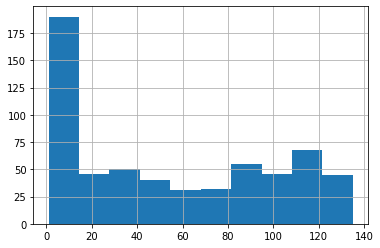

In [378]:
# Number of at-bats (first month) - use this to filter players (may be taken care of by top 300)
df_events.groupby('batter').count()['game_date'].hist()

What is the percent probability of hitting a HR in a given at-bat?

Factors of hitting home run:
- opposing team
- opposing pitcher
- time since last hitting HR
- number of HR
- HR per at bat rate
    

### Feature engineering - pitcher's HRs per at-bat

In [424]:
# Franmil's opposing starting pitcher on 5/3/19 was Clayton Kershaw (608331)

# get HR rate for Fried up to that point


sql_query = """
(SELECT "game_date", "batter", "pitcher", "events" FROM statcast
WHERE "pitcher"=477132 AND 
"game_date" BETWEEN '2019-03-28' AND '2019-04-30'
AND "events" IS NOT NULL)
"""

df_events = pd.read_sql_query(sql_query,con)


In [425]:
df_events.head()

,game_date,batter,pitcher,events
0,2019-04-21,518735.0,477132.0,field_out
1,2019-04-27,668804.0,477132.0,double
2,2019-04-27,465041.0,477132.0,field_out
3,2019-04-27,605137.0,477132.0,field_out
4,2019-04-27,466320.0,477132.0,strikeout


In [426]:
df_events[df_events['events']=='home_run']

,game_date,batter,pitcher,events
19,2019-04-21,456715.0,477132.0,home_run
71,2019-04-15,624577.0,477132.0,home_run


In [428]:
def return_df_metric_rate_pitcher(metric, pitcher_id):

    sql_query = """
    SELECT "game_date", "batter", "pitcher", "events" FROM statcast
    WHERE "pitcher"= 
    """ + str(pitcher_id) + """
    AND "game_date" BETWEEN '2019-03-28' AND '2019-04-30'
    AND "events" IS NOT NULL
    """

    df_events = pd.read_sql_query(sql_query,con)
    
    df_summary = df_events.groupby('events').count()['game_date'] / df_events.count()[0]
    return df_summary[metric]
    #return df_events

In [429]:
# Kershaw's HR rate on 5/3/19 (Reyes' opposing starting pitcher)
return_df_metric_rate_pitcher('home_run', 477132)

0.02702702702702703

In [430]:
# Jack Flaherty's HR rate on 5/3/19  (Schwarber's opposing starting pitcher) 
return_df_metric_rate_pitcher('home_run', 656427)

0.05384615384615385

In [ ]:
# What is the probability of Reyes hitting 1 home run off starting pitcher on 5/3/19?





## Model with linear regression - one variable

In [356]:
sql_query = """
(SELECT "game_date", "batter", "events" FROM statcast
WHERE "batter"=614177 AND 
"game_date" > '2019-01-01' AND
"events" IS NOT NULL)
"""

df_fr19_events = pd.read_sql_query(sql_query,con)

In [357]:
df_fr19_events.head()

,game_date,batter,events
0,2019-09-26,614177.0,strikeout
1,2019-09-28,614177.0,double
2,2019-09-28,614177.0,home_run
3,2019-09-28,614177.0,field_out
4,2019-09-26,614177.0,field_out


In [346]:
df_sc.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
0,0,FC,2018-10-01,92.2,-1.9690,6.2644,Kenley Jansen,467827.0,445276.0,strikeout,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
1,1,FC,2018-10-01,93.0,-1.7689,6.2976,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
2,2,FC,2018-10-01,91.6,-1.7451,6.2154,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
3,3,FF,2018-10-01,93.1,-1.4250,6.1929,Kenley Jansen,467827.0,445276.0,NaN,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard
4,4,FC,2018-10-01,91.4,-1.9144,6.2641,Kenley Jansen,435622.0,445276.0,strikeout,...,5.0,2.0,2.0,5.0,2.0,5.0,2.0,5.0,Standard,Standard


## Get statcast data for the matchup

**Make a database**

In [17]:
# Statcast data
df_sc = statcast('2019-04-01', '2019-05-30', team='SD')

This is a large query, it may take a moment to complete
Completed sub-query from 2019-04-01 to 2019-04-06
Completed sub-query from 2019-04-07 to 2019-04-12
Completed sub-query from 2019-04-13 to 2019-04-18
Completed sub-query from 2019-04-19 to 2019-04-24
Completed sub-query from 2019-04-25 to 2019-04-30
Completed sub-query from 2019-05-01 to 2019-05-06
Completed sub-query from 2019-05-07 to 2019-05-12
Completed sub-query from 2019-05-13 to 2019-05-18
Completed sub-query from 2019-05-19 to 2019-05-24
Completed sub-query from 2019-05-25 to 2019-05-30


In [34]:
df_sc_bat = df_sc[df_sc['batter']==int(batter['key_mlbam'])]  # & (df_sc['pitcher']==int(pitcher_info['key_mlbam'])))]

In [35]:
df_sc_bat.head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
11,3252,FF,2019-05-29,90.0,1.6173,5.2746,Nestor Cortes Jr.,592518.0,641482.0,walk,...,7.0,0.0,0.0,7.0,0.0,7.0,0.0,7.0,Standard,Standard
12,3269,SL,2019-05-29,81.4,1.9681,5.2551,Nestor Cortes Jr.,592518.0,641482.0,NaN,...,7.0,0.0,0.0,7.0,0.0,7.0,0.0,7.0,Standard,Standard
13,3274,SL,2019-05-29,82.9,1.7562,5.3481,Nestor Cortes Jr.,592518.0,641482.0,NaN,...,7.0,0.0,0.0,7.0,0.0,7.0,0.0,7.0,Standard,Standard
14,3290,FF,2019-05-29,90.0,1.4620,5.3794,Nestor Cortes Jr.,592518.0,641482.0,NaN,...,7.0,0.0,0.0,7.0,0.0,7.0,0.0,7.0,Standard,Standard
15,3296,FF,2019-05-29,90.5,1.8463,5.3143,Nestor Cortes Jr.,592518.0,641482.0,NaN,...,7.0,0.0,0.0,7.0,0.0,7.0,0.0,7.0,Standard,Standard


In [37]:
df_sc_bat_pitch = df_sc_bat[df_sc_bat['pitcher']==int(pitcher_info['key_mlbam'])]

## Basic year long matchup

In [48]:
df_batting.columns[df_batting.columns.str.contains('id')]

Index([], dtype='object')

## Basic results of matchup

In [44]:
df_sc_bat_pitch[df_sc_bat_pitch['events'].notna()]

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
4066,17337,SL,2019-05-14,86.0,1.7186,6.3372,Clayton Kershaw,592518.0,477132.0,single,...,6.0,3.0,3.0,6.0,3.0,6.0,3.0,6.0,Infield shift,Standard
4142,18400,FF,2019-05-14,89.7,1.1706,6.3895,Clayton Kershaw,592518.0,477132.0,home_run,...,4.0,1.0,1.0,4.0,1.0,4.0,1.0,4.0,Infield shift,Standard
4237,19733,SL,2019-05-14,87.0,1.6145,6.4089,Clayton Kershaw,592518.0,477132.0,strikeout,...,0.0,1.0,1.0,0.0,1.0,0.0,1.0,0.0,Infield shift,Standard
6712,14244,FF,2019-05-03,88.7,1.5950,6.2012,Clayton Kershaw,592518.0,477132.0,field_out,...,3.0,2.0,3.0,2.0,2.0,3.0,3.0,2.0,Infield shift,Standard
6805,15534,FF,2019-05-03,91.8,1.3058,6.2756,Clayton Kershaw,592518.0,477132.0,field_out,...,3.0,0.0,3.0,0.0,0.0,3.0,3.0,0.0,Infield shift,Standard
6861,16322,SL,2019-05-03,88.0,1.2369,6.3348,Clayton Kershaw,592518.0,477132.0,home_run,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,Standard,Standard


In [45]:
df_sc_bat_pitch[df_sc_bat_pitch['events']!='NaN'].head()

,index,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,...,home_score,away_score,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment
4066,17337,SL,2019-05-14,86.0,1.7186,6.3372,Clayton Kershaw,592518.0,477132.0,single,...,6.0,3.0,3.0,6.0,3.0,6.0,3.0,6.0,Infield shift,Standard
4067,17351,FF,2019-05-14,89.3,1.5819,6.2710,Clayton Kershaw,592518.0,477132.0,NaN,...,6.0,3.0,3.0,6.0,3.0,6.0,3.0,6.0,Infield shift,Standard
4068,17367,SL,2019-05-14,86.5,1.7675,6.2919,Clayton Kershaw,592518.0,477132.0,NaN,...,6.0,3.0,3.0,6.0,3.0,6.0,3.0,6.0,Infield shift,Standard
4142,18400,FF,2019-05-14,89.7,1.1706,6.3895,Clayton Kershaw,592518.0,477132.0,home_run,...,4.0,1.0,1.0,4.0,1.0,4.0,1.0,4.0,Infield shift,Standard
4143,18410,CU,2019-05-14,75.4,1.0129,6.4930,Clayton Kershaw,592518.0,477132.0,NaN,...,4.0,1.0,1.0,4.0,1.0,4.0,1.0,4.0,Infield shift,Standard


Get basic statistics - see who does better

batting metrics that determine if someone wins? HR, RBI, batting avg?
Standard categories are AVE, HR, R, RBI, and SB. Other popular ones are OPS, SP%. Points leagues also count K’s and award points for each base (1 for single, 2 for double, etc).



In [33]:
df_sc_bat['pitcher'].unique()

array([], dtype=float64)

# Other

In [433]:
#from flask import Flask

# Jupyter tricks

In [11]:
help(sdftatcast)sdf
help(sdftatcast)
help(sdftatcast)
help(sdftatcast)
help(sdftatcast)sdf

Help on function statcast in module pybaseball.statcast:

statcast(start_dt=None, end_dt=None, team=None, verbose=True)
    Pulls statcast play-level data from Baseball Savant for a given date range.
    
    INPUTS:
    start_dt: YYYY-MM-DD : the first date for which you want statcast data
    end_dt: YYYY-MM-DD : the last date for which you want statcast data
    team: optional (defaults to None) : city abbreviation of the team you want data for (e.g. SEA or BOS)
    
    If no arguments are provided, this will return yesterday's statcast data. If one date is provided, it will return that date's statcast data.



# Evaluate on pybaseball scraping serially

In [ ]:
# Input

In [3]:
# Pitch result designation dictionary
# A similar question and approach here https://www.reddit.com/r/Sabermetrics/comments/e130el/how_to_calculate_whiff_rate/
# Note that bunts are included
contact_desc = (['pitchout_hit_into_play_score', 'hit_into_play_score', 'hit_into_play',
                 'hit_by_pitch', 'hit_into_play_no_out', 'pitchout_hit_into_play_no_out',
                 'pitchout_hit_into_play'])
foul_desc = ['foul_pitchout', 'foul_bunt', 'bunt_foul_tip', 'foul', 'foul_tip']
takeball_desc = ['intent_ball', 'blocked_ball', 'pitchout', 'ball']
takestrike_desc = ['called_strike']
unknownstrike_desc = ['unknown_strike']
whiff_desc = ['swinging_strike_blocked', 'swinging_strike', 'missed_bunt', 'swinging_strike']

desc_dict = {'contact':contact_desc, 'foul':foul_desc, 'take_ball':takeball_desc,
             'take_strike':takestrike_desc, 'unknown_strike':unknownstrike_desc,
             'whiff':whiff_desc}

bat_stand_list = ['L', 'R']
zone_list = list(range(1, 13))
sw_types = list(desc_dict.keys())

In [13]:
def get_pitcher_pb_sc_data(pitcher):
    print(colored(pitcher, 'blue'))
    pitcher_for_lookup = pitcher.split()
    
    # Account for Chi Chi Gonzales since I'm splitting by space
    if len(pitcher_for_lookup) > 2:
        p_id = playerid_lookup(pitcher_for_lookup[2], pitcher_for_lookup[0] + ' ' + pitcher_for_lookup[1])
    else:
        p_id = playerid_lookup(pitcher_for_lookup[1], pitcher_for_lookup[0])
    
    # Account for common names
    if p_id.shape[0] > 1:
        p_id = p_id[p_id['mlb_played_last'] > 2008]
    df_pitcher_sc = statcast_pitcher('2019-03-28', '2019-09-29', player_id = int(p_id['key_mlbam']))
    
    # Swing designation info
    df_pitcher_sc['sw_type'] = None
    for key, value in desc_dict.items():
        df_pitcher_sc.loc[df_pitcher_sc['description'].isin(value), 'sw_type'] = key
    df_pitcher_sc['sw_true'] = 0
    df_pitcher_sc.loc[df_pitcher_sc['sw_type'].isin(['whiff', 'contact', 'foul']), 'sw_true'] = 1
    
    return p_id, df_pitcher_sc

In [5]:
# Example
pitcher = 'Gerrit Cole'
df_pitcher_sc_cole = get_pitcher_pb_sc_data(pitcher)

Gerrit Cole
Gathering player lookup table. This may take a moment.
Gathering Player Data


In [18]:
%%timeit

pitcher_list = (['Gerrit Cole',
                 'Justin Verlander',
                 'Caleb Smith',
                 'Chris Paddack',
                 'Reynaldo Lopez',
                 'Robbie Ray',
                 'Zach Eflin',
                 'Dylan Bundy',
                 'Zach Plesac',
                 'Merrill Kelly'])

92.4 ns ± 6.55 ns per loop (mean ± std. dev. of 7 runs, 10000000 loops each)


In [6]:

# Make a list of 10 pitchers as a test set
pitcher_list = (['Gerrit Cole',
                 'Justin Verlander',
                 'Caleb Smith',
                 'Chris Paddack',
                 'Reynaldo Lopez',
                 'Robbie Ray',
                 'Zach Eflin',
                 'Dylan Bundy',
                 'Zach Plesac',
                 'Merrill Kelly'])

# Make a list of 10 pitchers that includes a name not in the database as a test set that can throw an error
pitcher_list_werror = (['Gerrit Cole',
                 'Justin Verlander',
                 'Caleb Smith',
                 'Chris Paddack',
                 'Ben Lacar',
                 'Robbie Ray',
                 'Zach Eflin',
                 'Dylan Bundy',
                 'Zach Plesac',
                 'Merrill Kelly'])

In [7]:
# Done serially (two pitchers), takes 21.4 s
for pitcher in pitcher_list[0:2]:
    print(pitcher)
    df_pitcher_sc = get_pitcher_pb_sc_data(pitcher)
    
%%time

Gerrit Cole
Gerrit Cole
Gathering player lookup table. This may take a moment.
Gathering Player Data
Justin Verlander
Justin Verlander
Gathering player lookup table. This may take a moment.
Gathering Player Data


UsageError: Line magic function `%%time` not found.


# Evaluate on pybaseball scraping serially

I mainly modified functions based on [this StackOverflow post](https://stackoverflow.com/questions/16982569/making-multiple-api-calls-in-parallel-using-python-ipython).

- What happens if # of threads > # items to download?
- What happens if # items to download > # of threads?
- What happens if you max out the threads? (How do you know the max?)
- What if there is an error in an item you download?
- How do you do a loop with each pass through the loop doing a batch download? (e.g., scrape 10 items 2 at a time, so 5 passes through the loop)


In [8]:
def get_pitcher_pb_sc_data_range(pitcher_range, store=None):
    """process a number of ids, storing the results in a dict"""
    if store is None:
        store = {}
    for pitcher in pitcher_range:
        # Easy way to skip if there's an error
        try:
            store[pitcher] = get_pitcher_pb_sc_data(pitcher)
        except:
            continue
    return store

In [9]:
from threading import Thread

In [10]:
# def threaded_process_range(nthreads, id_range):
#     """process the id range in a specified number of threads"""
#     store = {}
#     threads = []
#     # create the threads
#     for i in range(nthreads):
#         ids = id_range[i::nthreads]
#         t = Thread(target=process_range, args=(ids,store))
#         threads.append(t)

#     # start the threads
#     [ t.start() for t in threads ]
#     # wait for the threads to finish
#     [ t.join() for t in threads ]
#     return store

In [11]:
def threaded_process_range(nthreads, pitcher_list):
    """process the pitcher list in a specified number of threads"""
    store = {}
    threads = []
    # create the threads
    for i in range(nthreads):
        ids = pitcher_list[i::nthreads]
        t = Thread(target=get_pitcher_pb_sc_data_range, args=(ids,store))
        threads.append(t)

    # start the threads
    [ t.start() for t in threads ]
    # wait for the threads to finish
    [ t.join() for t in threads ]
    return store

In [12]:
my_store = threaded_process_range(4, pitcher_list)

Gerrit Cole
Gathering player lookup table. This may take a moment.
Justin Verlander
Gathering player lookup table. This may take a moment.
Caleb Smith
Gathering player lookup table. This may take a moment.
Chris Paddack
Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data
Dylan Bundy
Gathering player lookup table. This may take a moment.
Reynaldo Lopez
Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data
Zach Eflin
Gathering player lookup table. This may take a moment.
Robbie Ray
Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data
Zach Plesac
Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data
Gathering Player Data
Merrill Kelly
Gathering player lookup table. This may take a moment.
Gathering Player Data


In [63]:
my_store = threaded_process_range(4, pitcher_list_werror)

Gerrit Cole
Gathering player lookup table. This may take a moment.
Justin Verlander
Gathering player lookup table. This may take a moment.Caleb Smith

Gathering player lookup table. This may take a moment.
Ben Lacar
Gathering player lookup table. This may take a moment.
Gathering Player Data
Gathering Player Data
Gathering Player Data


In [13]:
my_store.keys()

dict_keys(['Chris Paddack', 'Gerrit Cole', 'Caleb Smith', 'Justin Verlander', 'Dylan Bundy', 'Reynaldo Lopez', 'Zach Eflin', 'Robbie Ray', 'Zach Plesac', 'Merrill Kelly'])

In [14]:
my_store['Gerrit Cole'][1]

,pitch_type,game_date,release_speed,release_pos_x,release_pos_z,player_name,batter,pitcher,events,description,...,bat_score,fld_score,post_away_score,post_home_score,post_bat_score,post_fld_score,if_fielding_alignment,of_fielding_alignment,sw_type,sw_true
0,FF,2019-09-29,98.4,-1.9530,5.7396,Gerrit Cole,592230,543037,strikeout,swinging_strike,...,1,8,8,1,1,8,Infield shift,Standard,whiff,1
1,FF,2019-09-29,99.0,-1.8961,5.7786,Gerrit Cole,592230,543037,NaN,ball,...,1,8,8,1,1,8,Infield shift,Standard,take_ball,0
2,KC,2019-09-29,86.2,-1.9253,5.7561,Gerrit Cole,592230,543037,NaN,foul,...,1,8,8,1,1,8,Infield shift,Standard,foul,1
3,FF,2019-09-29,99.4,-1.9853,5.7987,Gerrit Cole,592230,543037,NaN,foul,...,1,8,8,1,1,8,Infield shift,Standard,foul,1
4,FF,2019-09-29,98.5,-1.9848,5.7508,Gerrit Cole,592230,543037,NaN,swinging_strike,...,1,8,8,1,1,8,Infield shift,Standard,whiff,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3357,SL,2019-03-29,89.8,-2.3465,5.9531,Gerrit Cole,640457,543037,NaN,foul,...,0,0,0,0,0,0,Infield shift,Standard,foul,1
3358,FF,2019-03-29,96.3,-2.1579,5.8887,Gerrit Cole,640457,543037,NaN,foul,...,0,0,0,0,0,0,Infield shift,Standard,foul,1
3359,SL,2019-03-29,88.5,-2.3414,5.9628,Gerrit Cole,640457,543037,NaN,ball,...,0,0,0,0,0,0,Infield shift,Standard,take_ball,0
3360,FT,2019-03-29,96.7,-2.3392,5.7665,Gerrit Cole,640457,543037,NaN,ball,...,0,0,0,0,0,0,Infield shift,Standard,take_ball,0


# What are threads? What are processes and what is going on?

In [57]:
my_list = ['Kawhi Leonard', 'Kevin Durant', 'Klay Thompson']

In [59]:
for player in my_list:
    print(player.lower().replace(' ', '-'))
    

kawhi-leonard
kevin-durant
klay-thompson


In [ ]:
# https://www.foxsports.com/nba/kevin-durant-player-injuries

In [43]:
%%bash
mkdir -p test_dir
ls
rm -r test_dir
ls

DS_dev_setup_part_1.html
DS_dev_setup_part_2.ipynb
DS_sql_setup_part_3.ipynb
Qs_for_Eric.txt
births2012_downsampled.csv
daily_fantasy_baseball_player_predictor.ipynb
edu_data_explore
explore_data_insight_env.ipynb
multithreading_wpybaseball.ipynb
test_dir
test_insight_env_wpostgreSQL.ipynb
DS_dev_setup_part_1.html
DS_dev_setup_part_2.ipynb
DS_sql_setup_part_3.ipynb
Qs_for_Eric.txt
births2012_downsampled.csv
daily_fantasy_baseball_player_predictor.ipynb
edu_data_explore
explore_data_insight_env.ipynb
multithreading_wpybaseball.ipynb
test_insight_env_wpostgreSQL.ipynb


In [16]:
[print(i) for i in data.columns]

Name
Team
Age
G
AB
PA
H
1B
2B
3B
HR
R
RBI
BB
IBB
SO
HBP
SF
SH
GDP
SB
CS
AVG
GB
FB
LD
IFFB
Pitches
Balls
Strikes
IFH
BU
BUH
BB%
K%
BB/K
OBP
SLG
OPS
ISO
BABIP
GB/FB
LD%
GB%
FB%
IFFB%
HR/FB
IFH%
BUH%
wOBA
wRAA
wRC
Bat
Fld
Rep
Pos
RAR
WAR
Dol
Spd
wRC+
WPA
-WPA
+WPA
RE24
REW
pLI
phLI
PH
WPA/LI
Clutch
FB% (Pitch)
FBv
SL%
SLv
CT%
CTv
CB%
CBv
CH%
CHv
SF%
SFv
KN%
KNv
XX%
PO%
wFB
wSL
wCT
wCB
wCH
wSF
wKN
wFB/C
wSL/C
wCT/C
wCB/C
wCH/C
wSF/C
wKN/C
O-Swing%
Z-Swing%
Swing%
O-Contact%
Z-Contact%
Contact%
Zone%
F-Strike%
SwStr%
BsR
FA% (pfx)
FT% (pfx)
FC% (pfx)
FS% (pfx)
FO% (pfx)
SI% (pfx)
SL% (pfx)
CU% (pfx)
KC% (pfx)
EP% (pfx)
CH% (pfx)
SC% (pfx)
KN% (pfx)
UN% (pfx)
vFA (pfx)
vFT (pfx)
vFC (pfx)
vFS (pfx)
vFO (pfx)
vSI (pfx)
vSL (pfx)
vCU (pfx)
vKC (pfx)
vEP (pfx)
vCH (pfx)
vSC (pfx)
vKN (pfx)
FA-X (pfx)
FT-X (pfx)
FC-X (pfx)
FS-X (pfx)
FO-X (pfx)
SI-X (pfx)
SL-X (pfx)
CU-X (pfx)
KC-X (pfx)
EP-X (pfx)
CH-X (pfx)
SC-X (pfx)
KN-X (pfx)
FA-Z (pfx)
FT-Z (pfx)
FC-Z (pfx)
FS-Z (pfx)
FO-Z (pfx)
SI-Z (pfx)

[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,

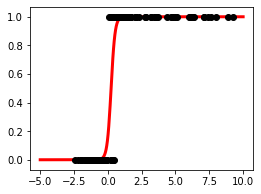

In [647]:

import numpy as np
import matplotlib.pyplot as plt

from sklearn import linear_model
from scipy.special import expit

# General a toy dataset:s it's just a straight line with some Gaussian noise:
xmin, xmax = -5, 5
n_samples = 100
np.random.seed(0)
X = np.random.normal(size=n_samples)
y = (X > 0).astype(np.float)
X[X > 0] *= 4
X += .3 * np.random.normal(size=n_samples)

X = X[:, np.newaxis]

# Fit the classifier
clf = linear_model.LogisticRegression(C=1e5)
clf.fit(X, y)

# and plot the result
plt.figure(1, figsize=(4, 3))
plt.clf()
plt.scatter(X.ravel(), y, color='black', zorder=20)
X_test = np.linspace(-5, 10, 300)

loss = expit(X_test * clf.coef_ + clf.intercept_).ravel()
plt.plot(X_test, loss, color='red', linewidth=3)